In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm
from matplotlib import rc
from numpy import inf
import os

from os import listdir


import uproot3


rc('text', usetex=True)

import matplotlib as mpl
rc('font', family='serif')
rc('text', usetex=True)
rc('font', size=22)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

#
mpl.rcParams.update({'font.size': 19})
#mpl.rcParams.update({'legend.fontsize': 18})
mpl.rcParams.update({'xtick.labelsize': 18}) 
mpl.rcParams.update({'ytick.labelsize': 18}) 
mpl.rcParams.update({'text.usetex' : False})
mpl.rcParams.update({'axes.labelsize': 18}) 
mpl.rcParams.update({'legend.frameon': False}) 

#import mplhep as hep
#hep.set_style(hep.style.ROOT)
print(pd.__version__)

0.25.3


/home/miguel/.local/lib/python3.8/site-packages/uproot3/__init__.py:127: FutureWarning: Consider switching from 'uproot3' to 'uproot', since the new interface became the default in 2020.

    pip install -U uproot

In Python:

    >>> import uproot
    >>> with uproot.open(...) as file:
    ...

  warnings.warn(
/home/miguel/.local/lib/python3.8/site-packages/awkward0/__init__.py:12: FutureWarning: Consider switching from 'awkward0' to 'awkward', since the new interface became the default in 2020.

    pip install -U awkward

In Python:

    >>> import awkward as ak
    >>> new_style_array = ak.from_awkward0(old_style_array)
    >>> old_style_array = ak.to_awkward0(new_style_array)

  warnings.warn(


In [2]:
#
#gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.5)
#sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

In [3]:
# Define default plot styles
plot_style_0 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'linestyle': '--',
    'density': True
}

plot_style_1 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'density': True
}

plot_style_2 = {'alpha': 0.5, 'density': True}

plot_style_1A = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'density': False
}

plot_style_2A = {'alpha': 0.5, 'density': False}


In [4]:
def get_Dataframe(path, name='Data', tag=None):
    Files = listdir(path) 
    #print (Files)
    df = None
    for i, f in enumerate(Files):
        if( df is not None):
            if(df.shape[0]>5000000): continue
        #if(i>10):continue
        if name not in f: continue
        filename = path+f
        if not(tag is None) and (tag not in f): continue
        print ('filename is' , filename)
        
        temp_file = uproot3.open(filename)
        
        hasTree = False 
        
        print (temp_file.keys()) 
        
        if(len(temp_file.keys())<1):
            print('could not find %s, skipping'%name)
            continue
        
        if( not(name in str(temp_file.keys()[0]))):
            print('could not find %s, skipping'%name)
            continue
        
        for key in temp_file[name].keys():
            #print (key)
            if('minitree' in str(key)):
                hasTree=True
        if (not hasTree):
            print('file has not minitree, skipping')
            continue

        temp_tree = temp_file[name+'/minitree']

        
        temp_df = None
        
        if 'Data' not in name:
            try:
                temp_df   =  temp_tree.pandas.df(["jet*", "genjet*","Q2","gen_Q2","y",'gen_y',"e_*","gene*",'wgt','vertex_z','ptmiss','ptratio*','Empz','pth'], entrystop=3e7,flatten=True)
                df = pd.concat([df,temp_df])
            except ValueError:
                print ('oops, there is a problem in flattening the TTree ')
        else:
            try:
                temp_df   =  temp_tree.pandas.df(["jet*","Q2","y","e_*",'wgt','vertex_z','ptmiss','ptratio*','Empz','pth'], entrystop=3e7,flatten=True) 
                df = pd.concat([df,temp_df])
            except ValueError:
                print ('oops, there is a problem in flattening the TTree ')
        
        #try:
        #    df.shape[0]
        #except ValueError:
        #    print('no valid dataframe')
    print('####################################################################')
    if( not(df is None)):
        print('Dataframe has a total of ', df.shape[0], ' entries')
    else:
        print ('Dataframe has no entry, it is None')
    print('####################################################################')

    return df


In [5]:
def applyCut(inputDataframe, cut, text=None):
    dataframe = inputDataframe
    nbeforecut = dataframe.shape[0]
    cutDataframe = dataframe.query(cut)
    if text:
        print (text, cutDataframe.shape[0], ' fraction kept: %2.1f'%(100.0*float(cutDataframe.shape[0])/nbeforecut))
    return cutDataframe

In [6]:
def applyCutsJets(df,isMC=False):
    temp = df
    #temp = applyCut(temp, 'abs(vertex_z)<25 and vertex_z!=0','abs(vertex_z)<25 and and vertex_z!=0')
    #temp = applyCut(temp, 'tau1b>0 and tau1b<1', '0<tau1b<1')
    temp.eval('jet_px = jet_pt*cos(jet_phi)', inplace=True)
    temp.eval('jet_py = jet_pt*sin(jet_phi)', inplace=True)
    temp.eval('jet_pz = jet_pt*sinh(jet_eta)', inplace=True)

    temp.eval('jet_qt = sqrt( (jet_px + e_px)**2 + (jet_py + e_py)**2) ', inplace=True)
    temp.eval('jet_qtnorm = jet_qt/sqrt(Q2)', inplace=True)
    temp.eval('e_pt = sqrt(e_px*e_px + e_py*e_py)',inplace=True)
    temp.eval('e_phi = arctan(e_py/e_px)', inplace=True)
    temp.eval('jet_phi = arctan(jet_py/jet_px)',inplace=True)
    
    temp.eval('qt_px = jet_px + e_px', inplace=True)
    temp.eval('qt_py = jet_py + e_py', inplace=True)
    temp.eval('qt_phi = arctan(qt_py/qt_px)',inplace=True)
    temp.eval('qt_dot_ept = (qt_px*e_px + qt_py*e_py)/(jet_qt*e_pt)', inplace=True)
    temp.eval('qt_dphi = arccos(qt_dot_ept)', inplace=True)
    temp.eval('qt_cos2phi = cos(2*qt_dphi)', inplace=True)

    temp.eval('jet_dphi = abs(e_phi-jet_phi)',inplace=True)
    temp.eval('logQ2= log(Q2)/2.3025850', inplace=True)
    temp.eval('Q = sqrt(Q2)', inplace=True)
    temp.eval('pthoverpte = pth/e_pt', inplace=True)
    temp = applyCut(temp, 'pass_reco==0 | ptmiss < 10', 'ptmiss<10')

    temp = applyCut(temp, 'pass_reco==0 | 0.08 < y < 0.7', '0.08 < y < 0.7')
    temp = applyCut(temp, 'pass_reco==0 | Q2>150', 'Q2>150')
   # temp = applyCut(temp, 'pass_reco==0 | Q2<10000', 'Q2<10000')
    temp = applyCut(temp, 'pass_reco==0 | Empz<65', 'Empz<65')
    temp = applyCut(temp, 'pass_reco==0 | Empz>45', 'Empz>45')
    temp = applyCut(temp, 'pass_reco==0 | jet_pt>5.0', 'jet pT > 5 GeV')
    temp = applyCut(temp, 'pass_reco==0 | jet_pt<150.0', 'jet pT < 150 GeV')

    temp = applyCut(temp, 'pass_reco==0 | jet_eta>-1.5', 'jet eta > -1.5')
    temp = applyCut(temp, 'pass_reco==0 | jet_eta<2.75', 'jet eta < 2.75')

    if(isMC):
        temp = applyCut(temp,'pass_truth>0',' pass_truth>0')

        temp.eval('gen_logQ2= log(gen_Q2)/2.3025850', inplace=True)   
        temp.eval('gen_Q    = sqrt(gen_Q2)', inplace=True)
        temp.eval('gene_pt = sqrt(gene_px*gene_px + gene_py*gene_py)',inplace=True)
        temp.eval('genjet_px = genjet_pt*cos(genjet_phi)', inplace=True)
        temp.eval('genjet_py = genjet_pt*sin(genjet_phi)', inplace=True)
        temp.eval('genjet_pz = genjet_pt*sinh(genjet_eta)', inplace=True)

        
        temp.eval('genjet_qt = sqrt( (genjet_px + gene_px)**2 + (genjet_py + gene_py)**2) ', inplace=True)
        temp.eval('genjet_qtnorm = genjet_qt/sqrt(gen_Q2)', inplace=True)
        temp.eval('gene_phi = arctan(gene_py/gene_px)', inplace=True)
        temp.eval('genjet_phi = arctan(genjet_py/genjet_px)',inplace=True)
        temp.eval('genjet_dphi = abs(gene_phi-genjet_phi)',inplace=True)
        
        temp.eval('genqt_px = genjet_px + gene_px', inplace=True)
        temp.eval('genqt_py = genjet_py + gene_py', inplace=True)
        temp.eval('genqt_phi = arctan(genqt_py/genqt_px)',inplace=True)
        temp.eval('genqt_dot_ept = (genqt_px*gene_px + genqt_py*gene_py)/(genjet_qt*gene_pt)', inplace=True)
        temp.eval('genqt_dphi = arccos(genqt_dot_ept)', inplace=True)
        temp.eval('genqt_cos2phi = cos(2*genqt_dphi)', inplace=True)

    #    temp.eval('genjet_qtnormept= genjet_qt/e_pt', inplace=True)
    #    temp.eval('genjet_qtnormjetpt= genjet_qt/genjet_pt', inplace=True)


    #df = applyCut(df, 'n_total>1', ' n>1')
    return temp

## Get dataframes, apply selection

In [7]:
#mc_name = 'Django'
#altmc_name = 'Rapgap'

mc_name = 'Rapgap'
altmc_name = 'Django'

In [8]:
mc_tag = 'nominal' ##could be "sys_0 or sys_1, etc"
data_tag  = 'nominal'
period = 'ep0607'

In [9]:
#path= '/data0/users/marratia/HERAdata/21-01-06-00-34-test17/out_ep0304/'
#path = '/data0/users/marratia/HERAdata/out_ep0607/'
path = '/home/miguel/data/hera/'
#path = '/home/miguel/data/hera/'
data = get_Dataframe(path, name='Data', tag=data_tag)

filename is /home/miguel/data/hera/Data_Eplus0607_0.nominal.root
[b'Data;1']
filename is /home/miguel/data/hera/Data_Eplus0607_2.nominal.root
[b'Data;1']
filename is /home/miguel/data/hera/Data_Eplus0607_3.nominal.root
[b'Data;1']
filename is /home/miguel/data/hera/Data_Eplus0607_1.nominal.root
[b'Data;1']
####################################################################
Dataframe has a total of  375783  entries
####################################################################



## Get Background

In [10]:
%%time
bkg_Compton = get_Dataframe(path, name='Compton', tag=data_tag)
bkg_CC = get_Dataframe(path, name='CCBkgd', tag=data_tag)
bkg_DVCS   = get_Dataframe(path, name='DVCS', tag=data_tag)

filename is /home/miguel/data/hera/Compton_Eplus0607_1.nominal.root
[b'Compton;1']
file has not minitree, skipping
filename is /home/miguel/data/hera/Compton_Eplus0607_8.nominal.root
[b'Compton;1']
file has not minitree, skipping
filename is /home/miguel/data/hera/Compton_Eplus0607_5.nominal.root
[b'Compton;1']
file has not minitree, skipping
filename is /home/miguel/data/hera/Compton_Eplus0607_4.nominal.root
[b'Compton;1']
file has not minitree, skipping
filename is /home/miguel/data/hera/Compton_Eplus0607_9.nominal.root
[b'Compton;1']
file has not minitree, skipping
filename is /home/miguel/data/hera/Compton_Eplus0607_2.nominal.root
[b'Compton;1']
file has not minitree, skipping
filename is /home/miguel/data/hera/Compton_Eplus0607_6.nominal.root
[b'Compton;1']
file has not minitree, skipping
filename is /home/miguel/data/hera/Compton_Eplus0607_7.nominal.root
[b'Compton;1']
file has not minitree, skipping
filename is /home/miguel/data/hera/Compton_Eplus0607_3.nominal.root
[b'Compton;1

In [11]:
%%time
bkg_DjBkgd = get_Dataframe(path, name='DjBkgd', tag=data_tag)
bkg_Pythia = get_Dataframe(path, name='Pythia', tag=data_tag)


filename is /home/miguel/data/hera/DjBkgd_0607_6.nominal.root
[b'DjBkgd;1']
filename is /home/miguel/data/hera/DjBkgd_0607_25.nominal.root
[b'DjBkgd;1']
filename is /home/miguel/data/hera/DjBkgd_0607_14.nominal.root
[b'DjBkgd;1']
filename is /home/miguel/data/hera/DjBkgd_0607_18.nominal.root
[b'DjBkgd;1']
filename is /home/miguel/data/hera/DjBkgd_0607_17.nominal.root
[b'DjBkgd;1']
filename is /home/miguel/data/hera/DjBkgd_0607_12.nominal.root
[b'DjBkgd;1']
####################################################################
Dataframe has a total of  5264766  entries
####################################################################
filename is /home/miguel/data/hera/Pythia_Eplus07_9.nominal.root
[b'Pythia;1']
oops, there is a problem in flattening the TTree 
filename is /home/miguel/data/hera/Pythia_Eplus07_17.nominal.root
[b'Pythia;1']
filename is /home/miguel/data/hera/Pythia_Eplus07_22.nominal.root
[b'Pythia;1']
oops, there is a problem in flattening the TTree 
filename is /home/m

## Get Signal MC

In [12]:
%%time 
mc = get_Dataframe(path, name=mc_name, tag=mc_tag)


filename is /home/miguel/data/hera/Rapgap_Eplus0607_116.nominal.root
[b'Rapgap;1']
filename is /home/miguel/data/hera/Rapgap_Eplus0607_8.nominal.root
[b'Rapgap;1']
filename is /home/miguel/data/hera/Rapgap_Eplus0607_101.nominal.root
[b'Rapgap;1']
filename is /home/miguel/data/hera/Rapgap_Eplus0607_107.nominal.root
[b'Rapgap;1']
####################################################################
Dataframe has a total of  5709963  entries
####################################################################
CPU times: user 9.57 s, sys: 356 ms, total: 9.92 s
Wall time: 9.93 s


In [13]:
%%time 

altmc = get_Dataframe(path, name=altmc_name, tag=mc_tag)


filename is /home/miguel/data/hera/Django_Eplus0607_8.nominal.root
[b'Django;1']
filename is /home/miguel/data/hera/Django_Eplus0607_129.nominal.root
[b'Django;1']
filename is /home/miguel/data/hera/Django_Eplus0607_137.nominal.root
[b'Django;1']
filename is /home/miguel/data/hera/Django_Eplus0607_134.nominal.root
[b'Django;1']
####################################################################
Dataframe has a total of  5973690  entries
####################################################################
CPU times: user 9.68 s, sys: 408 ms, total: 10.1 s
Wall time: 10.1 s


## Define the pass_reco and pass_tuth flags. i.e. whether row in the dataframe jet has a reco-level jet, and whether it has a valid truth-level jet. 

In [14]:
%%time 
mc['pass_reco'] = np.where(mc['jet_pt']>0, 1, 0)
mc['pass_truth'] = np.where(mc['genjet_pt']*mc['Q2']>0, 1, 0)

altmc['pass_reco'] = np.where(altmc['jet_pt']>0, 1, 0)
altmc['pass_truth'] = np.where(altmc['genjet_pt']*altmc['Q2']>0, 1, 0)



CPU times: user 101 ms, sys: 4.8 ms, total: 106 ms
Wall time: 88.5 ms


In [15]:
bkg_Pythia['pass_reco'] = np.where(bkg_Pythia['jet_pt']>0, 1, 0)
bkg_DjBkgd['pass_reco'] = np.where(bkg_DjBkgd['jet_pt']>0, 1, 0)
bkg_CC['pass_reco'] = np.where(bkg_CC['jet_pt']>0, 1, 0)


In [16]:
%%time 
data['pass_reco'] = np.where(data['jet_pt']>0, 1, 0)

print('Selecting data events\n')
data = applyCutsJets(data)
data.keys()

Selecting data events

ptmiss<10 372273  fraction kept: 99.1
0.08 < y < 0.7 303073  fraction kept: 81.4
Q2>150 259178  fraction kept: 85.5
Empz<65 259178  fraction kept: 100.0
Empz>45 259178  fraction kept: 100.0
jet pT > 5 GeV 259178  fraction kept: 100.0
jet pT < 150 GeV 259178  fraction kept: 100.0
jet eta > -1.5 258694  fraction kept: 99.8
jet eta < 2.75 258684  fraction kept: 100.0
CPU times: user 341 ms, sys: 16.1 ms, total: 357 ms
Wall time: 229 ms


Index(['jet_pt', 'jet_phi', 'jet_eta', 'jet_dphi', 'jet_z', 'Q2', 'y', 'e_px',
       'e_py', 'e_pz', 'wgt', 'vertex_z', 'ptmiss', 'ptratio_da',
       'ptratio_ele', 'Empz', 'pth', 'pass_reco', 'jet_px', 'jet_py', 'jet_pz',
       'jet_qt', 'jet_qtnorm', 'e_pt', 'e_phi', 'qt_px', 'qt_py', 'qt_phi',
       'qt_dot_ept', 'qt_dphi', 'qt_cos2phi', 'logQ2', 'Q', 'pthoverpte'],
      dtype='object')

In [17]:
bkg_Pythia = applyCutsJets(bkg_Pythia)
bkg_CC = applyCutsJets(bkg_CC)
bkg_DjBkgd = applyCutsJets(bkg_DjBkgd)

ptmiss<10 6170101  fraction kept: 100.0
0.08 < y < 0.7 6170092  fraction kept: 100.0
Q2>150 6170079  fraction kept: 100.0
Empz<65 6170079  fraction kept: 100.0
Empz>45 6170079  fraction kept: 100.0
jet pT > 5 GeV 6170079  fraction kept: 100.0
jet pT < 150 GeV 6170079  fraction kept: 100.0
jet eta > -1.5 6170079  fraction kept: 100.0
jet eta < 2.75 6170079  fraction kept: 100.0
ptmiss<10 482109  fraction kept: 100.0
0.08 < y < 0.7 482109  fraction kept: 100.0
Q2>150 482109  fraction kept: 100.0
Empz<65 482109  fraction kept: 100.0
Empz>45 482109  fraction kept: 100.0
jet pT > 5 GeV 482109  fraction kept: 100.0
jet pT < 150 GeV 482109  fraction kept: 100.0
jet eta > -1.5 482109  fraction kept: 100.0
jet eta < 2.75 482109  fraction kept: 100.0
ptmiss<10 5264384  fraction kept: 100.0
0.08 < y < 0.7 5262582  fraction kept: 100.0
Q2>150 5238135  fraction kept: 99.5
Empz<65 5238135  fraction kept: 100.0
Empz>45 5238135  fraction kept: 100.0
jet pT > 5 GeV 5238135  fraction kept: 100.0
jet pT 

In [18]:
%%time 
print('Selecting MC events\n')
mc   = applyCutsJets(mc, isMC=True)
print('Selecting MC events\n')
altmc   = applyCutsJets(altmc, isMC=True)

Selecting MC events

ptmiss<10 5695953  fraction kept: 99.8
0.08 < y < 0.7 5571241  fraction kept: 97.8
Q2>150 5418864  fraction kept: 97.3
Empz<65 5418864  fraction kept: 100.0
Empz>45 5418864  fraction kept: 100.0
jet pT > 5 GeV 5418864  fraction kept: 100.0
jet pT < 150 GeV 5418864  fraction kept: 100.0
jet eta > -1.5 5417397  fraction kept: 100.0
jet eta < 2.75 5417366  fraction kept: 100.0
 pass_truth>0 1415869  fraction kept: 26.1
Selecting MC events

ptmiss<10 5951602  fraction kept: 99.6
0.08 < y < 0.7 5834904  fraction kept: 98.0
Q2>150 5660756  fraction kept: 97.0
Empz<65 5660756  fraction kept: 100.0
Empz>45 5660756  fraction kept: 100.0
jet pT > 5 GeV 5660756  fraction kept: 100.0
jet pT < 150 GeV 5660756  fraction kept: 100.0
jet eta > -1.5 5659323  fraction kept: 100.0
jet eta < 2.75 5659287  fraction kept: 100.0
 pass_truth>0 1386697  fraction kept: 24.5
CPU times: user 9.92 s, sys: 2.46 s, total: 12.4 s
Wall time: 9.49 s


## Show all distributions

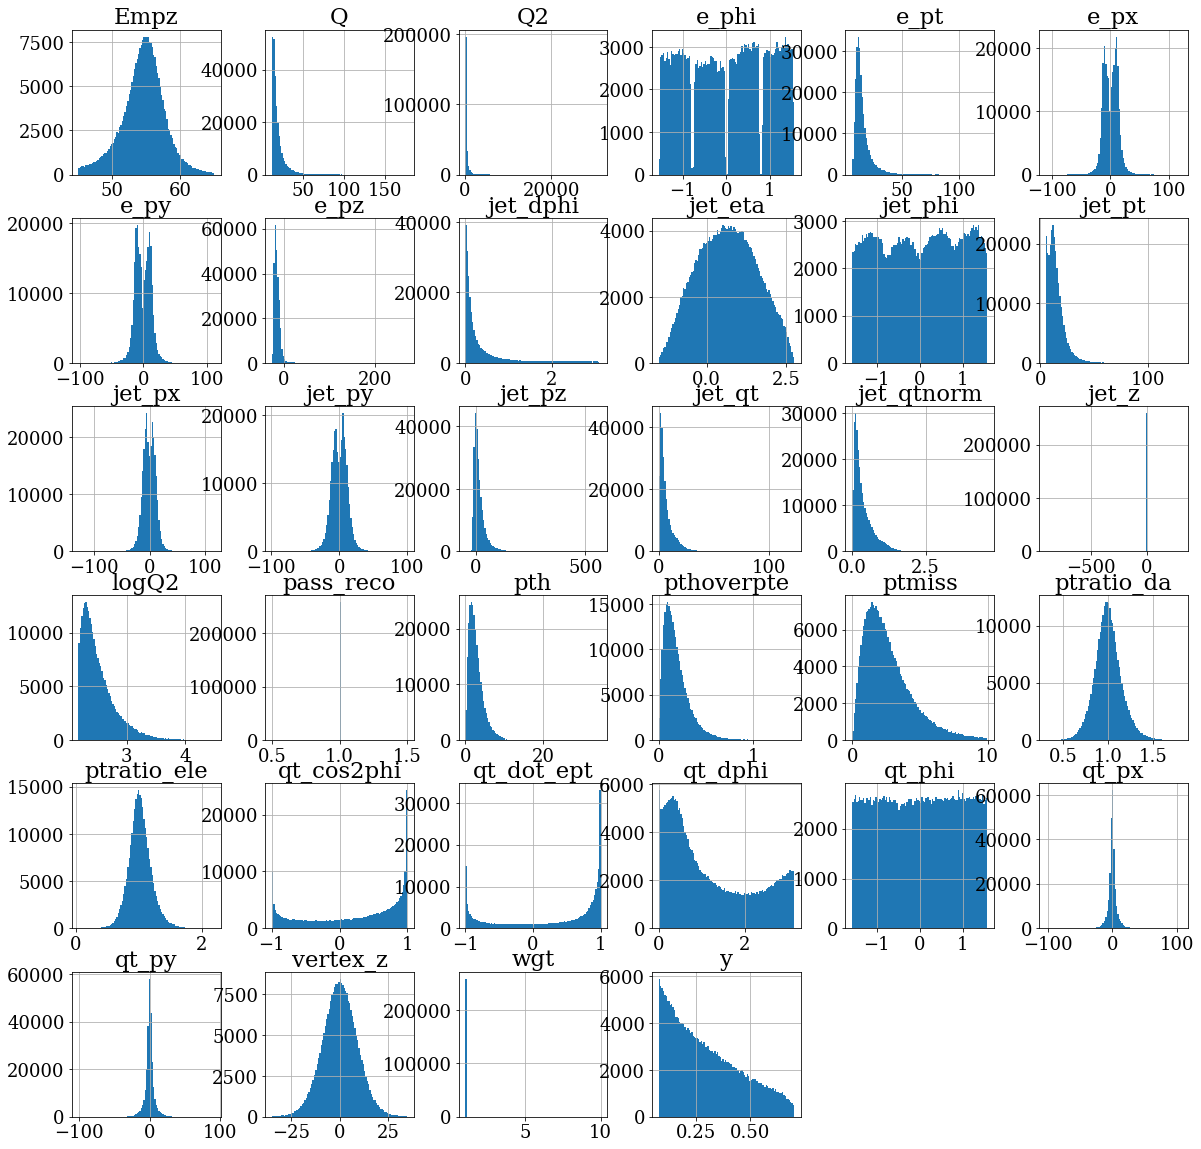

In [19]:
data.hist(figsize=(20,20),bins=100)
plt.show()

/usr/lib/python3/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/lib/python3/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


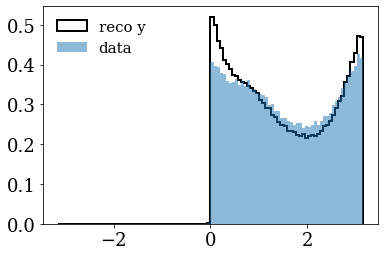

In [20]:
plt.hist(mc.query('pass_reco==1 and jet_pt>10')['qt_dphi'],weights = mc.query('pass_reco==1 and jet_pt>10')['wgt'], range=(-np.pi,np.pi),bins=100,**plot_style_1,label='reco y')
plt.hist(data.query('jet_pt>10')['qt_dphi'],range=(-np.pi,np.pi),bins=100, **plot_style_2, label='data')
plt.legend()
plt.show()

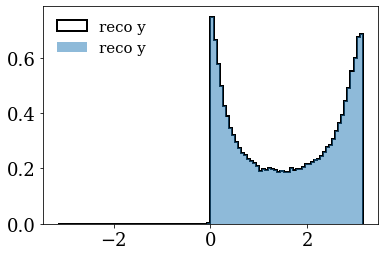

In [21]:
plt.hist(mc.query('pass_reco==1 and genjet_pt>20')['qt_dphi'],weights = mc.query('pass_reco==1 and genjet_pt>20')['wgt'], range=(-np.pi,np.pi),bins=100,**plot_style_1,label='reco y')
plt.hist(mc.query('genjet_pt>20')['qt_dphi'],weights = mc.query('genjet_pt>20')['wgt'], range=(-np.pi,np.pi),bins=100,**plot_style_2,label='reco y')

plt.legend()
plt.show()

## Control plots

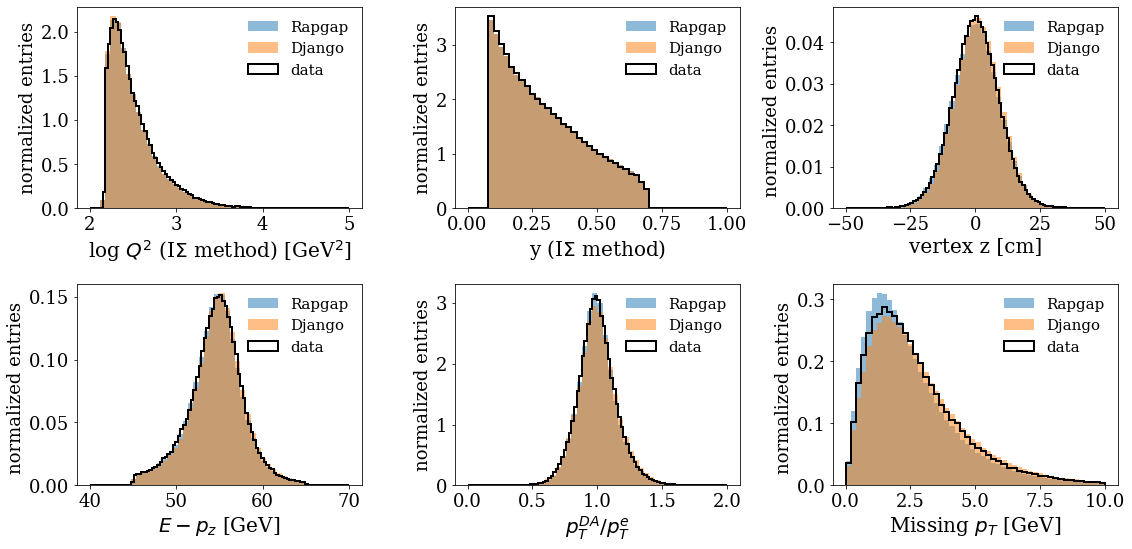

In [22]:
fig , ax = plt.subplots(2,3,figsize=(16,8))
ax = ax.flatten()
ax[2].hist(mc.query('pass_reco==1')['vertex_z'],weights = mc.query('pass_reco==1')['wgt'], range=(-50,50),bins=50,**plot_style_2,label=mc_name)
ax[2].hist(altmc.query('pass_reco==1')['vertex_z'],weights = altmc.query('pass_reco==1')['wgt'], range=(-50,50),bins=50,**plot_style_2,label=altmc_name)
ax[2].hist(data['vertex_z'],range=(-50,50),bins=100, **plot_style_1, label='data')
ax[2].set_xlabel('vertex z [cm]',fontsize=20)
ax[2].set_ylabel('normalized entries ')

ax[2].legend()

ax[3].hist(mc.query('pass_reco==1')['Empz'],weights = mc.query('pass_reco==1')['wgt'], range=(40,70),bins=50,**plot_style_2,label=mc_name)
ax[3].hist(altmc.query('pass_reco==1')['Empz'],weights = altmc.query('pass_reco==1')['wgt'], range=(40,70),bins=50,**plot_style_2,label=altmc_name)
ax[3].hist(data['Empz'],range=(40,70),bins=100, **plot_style_1, label='data')
ax[3].set_xlabel('$E - p_{z}$ [GeV]' ,fontsize=20)
ax[3].set_ylabel('normalized entries ')

ax[3].legend()

ax[4].hist(mc.query('pass_reco==1')['ptratio_da'],weights = mc.query('pass_reco==1')['wgt'], range=(0,2),bins=50,**plot_style_2,label=mc_name)
ax[4].hist(altmc.query('pass_reco==1')['ptratio_da'],weights = altmc.query('pass_reco==1')['wgt'], range=(0,2),bins=50,**plot_style_2,label=altmc_name)
ax[4].hist(data['ptratio_da'],range=(0,2),bins=100, **plot_style_1,label='data')
ax[4].set_xlabel('$p_{T}^{DA}/p_{T}^{e}$',fontsize=20)
ax[4].set_ylabel('normalized entries')

ax[4].legend()

ax[5].hist(mc.query('pass_reco==1')['ptmiss'],weights = mc.query('pass_reco==1')['wgt'], range=(0,10),bins=50,**plot_style_2,label=mc_name)
ax[5].hist(altmc.query('pass_reco==1')['ptmiss'],weights = altmc.query('pass_reco==1')['wgt'], range=(0,10),bins=50,**plot_style_2,label=altmc_name)
ax[5].hist(data['ptmiss'],range=(0,10),bins=50, **plot_style_1,label='data')
#ax[5].set_yscale('log')
ax[5].set_xlabel('Missing $p_{T}$ [GeV]',fontsize=20)
ax[5].set_ylabel('normalized entries ')
ax[5].legend()


ax[0].hist(mc.query('pass_reco==1')['logQ2'],weights = mc.query('pass_reco==1')['wgt'], range=(2,5),bins=50,**plot_style_2,label=mc_name)
ax[0].hist(altmc.query('pass_reco==1')['logQ2'],weights = altmc.query('pass_reco==1')['wgt'], range=(2,5),bins=50,**plot_style_2,label=altmc_name)
ax[0].hist(data['logQ2'],range=(2,5),bins=100, **plot_style_1,label='data')
ax[0].set_xlabel('log $Q^{2}$ (I$\Sigma$ method) [GeV$^{2}$]',fontsize=20)
ax[0].set_ylabel('normalized entries')

ax[0].legend()


ax[1].hist(mc.query('pass_reco==1')['y'],weights = mc.query('pass_reco==1')['wgt'], range=(0,1),bins=50,**plot_style_2,label=mc_name)
ax[1].hist(mc.query('pass_reco==1')['y'],weights = mc.query('pass_reco==1')['wgt'], range=(0,1),bins=50,**plot_style_2,label=altmc_name)
ax[1].hist(data['y'],range=(0,1),bins=50, **plot_style_1,label='data')
ax[1].set_xlabel('y (I$\Sigma$ method)', fontsize=20)
ax[1].set_ylabel('normalized entries')

ax[1].legend()
plt.tight_layout()

fig.savefig('figures/ControlPlotsEventVariables_%s_%s_%s_data_%s.png'%(mc_name,mc_tag,period,data_tag)) 

plt.show()

# Acceptance plots 

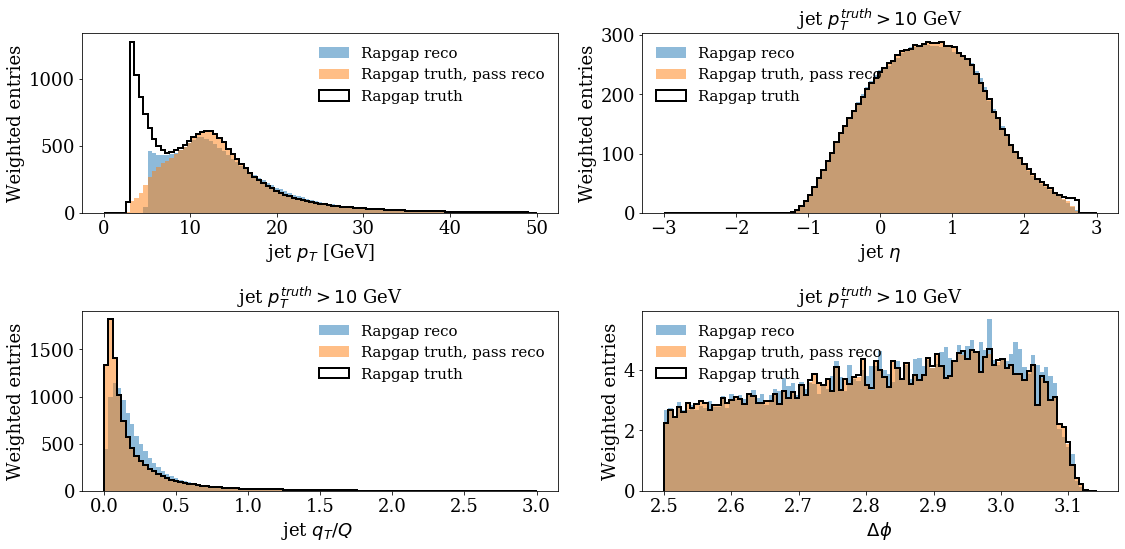

In [23]:
fig, ax = plt.subplots(2,2,figsize=(16,8))
bins = np.linspace(0,50,100)
ax=ax.flatten()
ax[0].hist(mc['jet_pt'], weights = mc['wgt'],bins=bins, label=mc_name+' reco', **plot_style_2A)
ax[0].hist(mc.query('pass_reco==1')['genjet_pt'],  weights = mc.query('pass_reco==1')['wgt'], bins=bins, label=mc_name+' truth, pass reco', **plot_style_2A)
ax[0].hist(mc['genjet_pt'], weights = mc['wgt'], bins=bins, label=mc_name+' truth', **plot_style_1A)
ax[0].set_xlabel('jet $p_{T}$ [GeV]',fontsize=18)
bins = np.linspace(-3.0,3.0,100)

cut = 'genjet_pt>10'

ax[1].hist(mc.query(cut)['jet_eta'], weights = mc.query(cut)['wgt'],bins=bins, label=mc_name+' reco', **plot_style_2A)
ax[1].hist(mc.query('pass_reco==1 and ' + cut )['genjet_eta'],  weights = mc.query('pass_reco==1 and ' + cut)['wgt'], bins=bins, label=mc_name+' truth, pass reco', **plot_style_2A)
ax[1].hist(mc.query(cut)['genjet_eta'], weights = mc.query(cut)['wgt'], bins=bins, label=mc_name+' truth', **plot_style_1A)
ax[1].set_xlabel('jet $\eta$ ',fontsize=18)
ax[1].set_title('jet $p_{T}^{truth}>10$ GeV',fontsize=18)

ax[0].set_ylabel('Weighted entries')
ax[1].set_ylabel('Weighted entries')
ax[2].set_ylabel('Weighted entries')
ax[3].set_ylabel('Weighted entries')

bins = np.linspace(0.0,3.0,100)
ax[2].hist(mc.query(cut)['jet_qtnorm'], weights = mc.query(cut)['wgt'],bins=bins, label=mc_name+' reco', **plot_style_2A)
ax[2].hist(mc.query('pass_reco==1 and ' + cut)['genjet_qtnorm'],  weights = mc.query('pass_reco==1 and ' + cut)['wgt'], bins=bins, label=mc_name+' truth, pass reco', **plot_style_2A)
ax[2].hist(mc.query(cut)['genjet_qtnorm'], weights = mc.query(cut)['wgt'], bins=bins, label=mc_name+' truth', **plot_style_1A)
ax[2].set_xlabel('jet $q_{T}/Q$  ',fontsize=18)
ax[2].set_title('jet $p_{T}^{truth}>10$ GeV',fontsize=18)



bins = np.linspace(2.5,np.pi,100)
ax[3].hist(mc.query(cut)['jet_dphi'], weights = mc.query(cut)['wgt'],bins=bins, label=mc_name+' reco', **plot_style_2A)
ax[3].hist(mc.query('pass_reco==1 and ' + cut)['genjet_dphi'],  weights = mc.query('pass_reco==1 and ' + cut)['wgt'], bins=bins, label=mc_name+' truth, pass reco', **plot_style_2A)
ax[3].hist(mc.query(cut)['genjet_dphi'], weights = mc.query(cut)['wgt'], bins=bins, label=mc_name+' truth', **plot_style_1A)
ax[3].set_xlabel(' $\Delta\phi$  ',fontsize=18)
ax[3].set_title('jet $p_{T}^{truth}>10$ GeV',fontsize=18)

ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend()
plt.tight_layout()

fig.savefig('figures/TruthReco_%s_%s_%s_data_%s.png'%(mc_name,mc_tag,period,data_tag)) 


## Check background

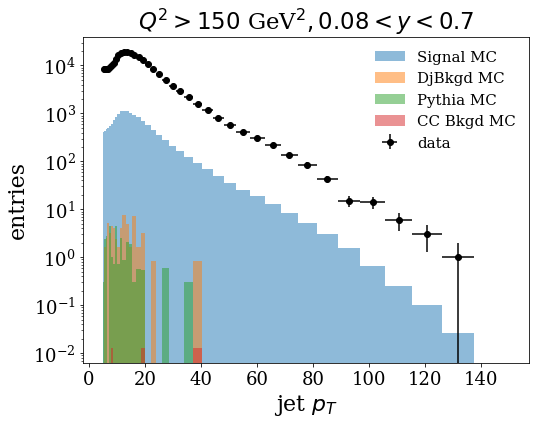

In [24]:
fig = plt.figure(figsize=(8,6))
bins = np.geomspace(5,150,40)

y , x = np.histogram(data.query('pass_reco==1')['jet_pt'],bins=bins)
xerr = (x[1:] - x[:-1])/2.0
x = (x[1:]+x[:-1])/2

plt.errorbar(x,y,yerr=np.sqrt(y),xerr=xerr,fmt='o',color='k',label='data')
plt.hist(mc.query('pass_reco==1')['jet_pt'],bins=bins,weights = mc.query('pass_reco==1')['wgt'], **plot_style_2A, label='Signal MC')
plt.hist(bkg_DjBkgd.query('gen_Q2>4 and gen_Q2<60 and pass_reco==1')['jet_pt'],weights = bkg_DjBkgd.query('gen_Q2>4 and gen_Q2<60 and pass_reco==1')['wgt'],bins=bins, **plot_style_2A, label='DjBkgd MC')
plt.hist(bkg_Pythia.query('pass_reco==1')['jet_pt'],weights = bkg_Pythia.query('pass_reco==1')['wgt'],bins=bins, **plot_style_2A, label='Pythia MC')
plt.hist(bkg_CC.query('pass_reco==1')['jet_pt'],weights = bkg_CC.query('pass_reco==1')['wgt'],bins=bins, **plot_style_2A, label='CC Bkgd MC')

plt.ylabel('entries',fontsize=22)
plt.yscale('log')
plt.title(r'$Q^{2}>150$ GeV$^{2}, 0.08<y<0.7$')
plt.legend(loc='best')
plt.xlabel('jet $p_{T}$',fontsize=22)
plt.show()

fig.savefig('figures/BackgroundEstimate_%s_%s_%s_data_%s.png'%(mc_name,mc_tag,period,data_tag)) 


## Event selection

In [25]:
label_DISselection = r'$Q^{2}>150$ GeV$^{2}, 0.08<y<0.7$'

In [26]:
data.head()

jet_pt   jet_phi   jet_eta  jet_dphi     jet_z          Q2  \
entry subentry                                                                  
1     0         13.375306  0.694599 -0.200293  0.056279  0.712882  186.193192   
      1          5.949738 -1.204232  2.355365  1.955110  0.028189  186.193192   
4     0         12.692886 -0.213480  0.209102  0.130793  0.722541  296.473389   
7     0         17.961945 -1.262607  0.770954  0.049207  2.665258  226.002777   
10    0          9.438538 -0.169292 -1.124625  0.448337  0.790033  260.205597   

                       y       e_px       e_py       e_pz  ...     e_phi  \
entry subentry                                             ...             
1     0         0.413862   7.575202   7.069456 -14.227906  ...  0.750877   
      1         0.413862   7.575202   7.069456 -14.227906  ...  0.750877   
4     0         0.235721  14.719972  -1.219937 -17.624556  ... -0.082687   
7     0         0.140928   3.730844 -14.082226 -23.870697  ... -1.311813   
10    0         0.685542   8.920532   2.555918  -6.776602  ...  0.279045   

                   qt_px     qt_py    qt_phi  qt_dot_ept   qt_dphi  \
entry subentry                                                       
1     0        -2.701188 -1.491773  0.504581   -0.969822  2.895296   
      1         9.707645  1.514992  0.154813    0.827551  0.596065   
4     0         2.315221  1.469210  0.565464    0.797201  0.648151   
7     0        -1.717625  3.033430 -1.055577   -0.967351  2.885356   
10    0        -0.383075  4.146164 -1.478665    0.185828  1.383882   

                qt_cos2phi     logQ2          Q  pthoverpte  
entry subentry                                               
1     0           0.881110  2.269964  13.645263    0.249644  
      1           0.369683  2.269964  13.645263    0.249644  
4     0           0.271060  2.471986  17.218403    0.291590  
7     0           0.871535  2.354114  15.033389    0.220944  
10    0          -0.930936  2.415317  16.130890    0.129416  

[5 rows x 34 columns]

In [27]:
mc.head()

jet_pt   jet_phi      jet_eta  jet_dphi        jet_z  \
entry subentry                                                              
2     0           16.420273  1.553756     0.587027  3.044224     0.728761   
      1            9.641730 -1.456244     1.784029  0.034224     0.161802   
4     0           14.567807 -0.377384    -0.395859  0.524154     0.679185   
      1        -9999.000000  0.689416 -9999.000000  1.590954 -9999.000000   
      2        -9999.000000  0.689416 -9999.000000  1.590954 -9999.000000   

                genjet_pt  genjet_phi  genjet_eta  genjet_z          Q2  ...  \
entry subentry                                                           ...   
2     0         20.568708   -1.467425    0.821434  0.846955  788.595337  ...   
      1          5.473908   -1.346081    2.155561  0.054393  788.595337  ...   
4     0         14.085672   -0.397176   -0.393945  0.653461  212.734039  ...   
      1          5.879607    0.214298    0.837583  0.115509  212.734039  ...   
      2          3.192867   -1.526671    1.398180  0.033691  212.734039  ...   

                genjet_qt  genjet_qtnorm  gene_phi  genjet_dphi   genqt_px  \
entry subentry                                                               
2     0          3.541956       0.127100 -1.491610     0.024185  -0.218442   
      1         18.670387       0.669973 -1.491610     0.145529   0.684249   
4     0          7.555617       0.523518 -0.901228     0.504051  -7.374407   
      1         12.774529       0.885129 -0.901228     1.115525  11.359911   
      2          6.723284       0.465847 -0.901228     0.625444   5.473955   

                 genqt_py  genqt_phi  genqt_dot_ept  genqt_dphi  genqt_cos2phi  
entry subentry                                                                  
2     0         -3.535213   1.509084       0.990090    0.140898       0.960558  
      1        -18.657845  -1.534139       0.999096    0.042530       0.996385  
4     0         -1.644833   0.219454      -0.435069    2.020911      -0.621430  
      1         -5.843030  -0.475066       0.910559    0.426162       0.658236  
      2         -3.903635  -0.619483       0.960572    0.281744       0.845397  

[5 rows x 60 columns]

### Define UniFold Algorithm


In [28]:
from __future__ import absolute_import, division, print_function
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
# Input multiple observables as tuple or list (i.e. theta0_G = (obs_1, obs_2, ...))





def weighted_binary_crossentropy(y_true, y_pred):
    weights = tf.gather(y_true, [1], axis=1) # event weights
    y_true = tf.gather(y_true, [0], axis=1) # actual y_true for loss
    
    # Clip the prediction value to prevent NaN's and Inf's
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    t_loss = -weights * ((y_true) * K.log(y_pred) +
                         (1 - y_true) * K.log(1 - y_pred))
    
    return K.mean(t_loss)
def multifold(num_observables, iterations, theta0_G, theta0_S,
              theta_unknown_S,weights_MC_sim=None,weights_MC_data=None,verbose=1):
    
    if weights_MC_sim is None:
        weights_MC_sim = np.ones(len(theta0_S))
    
    if weights_MC_data is None:
        weights_MC_data = np.ones(len(theta_unknown_S))
    
    
    theta0 = np.stack([theta0_G, theta0_S], axis=1)
    labels0 = np.zeros(len(theta0))
    theta_unknown = np.stack([theta_unknown_S, theta_unknown_S], axis=1)
    labels1 = np.ones(len(theta0_G))
    labels_unknown = np.ones(len(theta_unknown_S))
    
    xvals_1 = np.concatenate((theta0_S, theta_unknown_S))
    yvals_1 = np.concatenate((labels0, labels_unknown))
    xvals_2 = np.concatenate((theta0_G, theta0_G))
    yvals_2 = np.concatenate((labels0, labels1))
    weights = np.empty(shape=(iterations, 2, len(theta0_G)))
    
    inputs = Input((num_observables, ))
    hidden_layer_1 = Dense(50, activation='relu')(inputs)
    dropoutlayer = Dropout(0.1)(hidden_layer_1)
    hidden_layer_2 = Dense(50, activation='relu')(dropoutlayer)
    hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
    outputs = Dense(1, activation='sigmoid')(hidden_layer_3)
    model = Model(inputs=inputs, outputs=outputs)
    earlystopping = EarlyStopping(patience=30,
                              verbose=verbose,
                              restore_best_weights=True)
    
    # from NN (DCTR) 
    def reweight(events):
        f = model.predict(events, batch_size=5000)
        weights = f / (1. - f)
        return np.squeeze(np.nan_to_num(weights))
    
    
    
    weights_pull = weights_MC_sim
    weights_push = weights_MC_sim
    
    #weights_pull = np.ones(len(theta0_S))
    #weights_push = np.ones(len(theta0_S))
    
    history = {}
    history['step1'] = []
    history['step2'] = []
    for i in range(iterations):
        print("\nITERATION: {}\n".format(i + 1))
        print("STEP 1\n")
        
        weights_1 = np.concatenate((weights_push,weights_MC_data ))
        
        
      
        X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(
        xvals_1, yvals_1, weights_1)
        
        Y_train_1 = np.stack((Y_train_1, w_train_1), axis=1)
        Y_test_1 = np.stack((Y_test_1, w_test_1), axis=1)
            
            
        batch_size=5000
        model.compile(loss=weighted_binary_crossentropy,
                  optimizer='Adam',
                  metrics=['accuracy'])
        
        hist_s1 =  model.fit(X_train_1,
              Y_train_1,
              epochs=200,
              batch_size=batch_size,
              validation_data=(X_test_1, Y_test_1),
              callbacks=[earlystopping],
              verbose=verbose)
        
        history['step1'].append(hist_s1)
        weights_pull = weights_push * reweight(theta0_S)
        weights_pull[theta0_S[:,0]==-10] = 1
        weights[i, :1, :] = weights_pull
        
        print("\nSTEP 2\n")
        weights_2 = np.concatenate((weights_MC_sim, weights_pull))

        #weights_2 = np.concatenate((np.ones(len(theta0_G)), weights_pull))
        # ones for MC Truth (not MC weights), actual weights for (reweighted) MC Truth
        X_train_2, X_test_2, Y_train_2, Y_test_2, w_train_2, w_test_2 = train_test_split(
            xvals_2, yvals_2, weights_2)
    
        # zip ("hide") the weights with the labels
        Y_train_2 = np.stack((Y_train_2, w_train_2), axis=1)
        Y_test_2 = np.stack((Y_test_2, w_test_2), axis=1)
        model.compile(loss=weighted_binary_crossentropy,
                  optimizer='Adam',
                  metrics=['accuracy'])
        hist_s2 = model.fit(X_train_2,
              Y_train_2,
              epochs=200,
              batch_size=batch_size,
              validation_data=(X_test_2, Y_test_2),
              callbacks=[earlystopping],
              verbose=verbose)
        
        history['step2'].append(hist_s2)

        #weights_push = reweight(theta0_G)
        weights_push = weights_MC_sim * reweight(theta0_G)

        weights[i, 1:2, :] = weights_push
   
    return weights, model, history

    




In [29]:
print(tf.__version__)
print(tensorflow.keras.__version__)

print(np.__version__)

2.3.1
2.4.0
1.17.4


In [30]:
tf.random.set_seed(1234)
np.random.seed(1234)

## Define features with data

In [31]:
data_cut = data
n = int(len(data_cut)*1.5)
mc_cut = mc[:n]


print(len(mc_cut))
print(len(data_cut))

388026
258684


In [32]:
print(len(data_cut))
print(len(mc_cut.query('pass_reco==1'))) ##only what is really reconstructed counts
print(len(mc_cut)) ##only what is really reconstructed counts
ratio = len(mc_cut.query('pass_reco==1'))/len(data_cut)
print(ratio)

258684
301673
388026
1.1661834516243756


In [33]:
mc_cut.keys()

Index(['jet_pt', 'jet_phi', 'jet_eta', 'jet_dphi', 'jet_z', 'genjet_pt',
       'genjet_phi', 'genjet_eta', 'genjet_z', 'Q2', 'gen_Q2', 'y', 'gen_y',
       'e_px', 'e_py', 'e_pz', 'gene_px', 'gene_py', 'gene_pz', 'wgt',
       'vertex_z', 'ptmiss', 'ptratio_da', 'ptratio_ele', 'Empz', 'pth',
       'pass_reco', 'pass_truth', 'jet_px', 'jet_py', 'jet_pz', 'jet_qt',
       'jet_qtnorm', 'e_pt', 'e_phi', 'qt_px', 'qt_py', 'qt_phi', 'qt_dot_ept',
       'qt_dphi', 'qt_cos2phi', 'logQ2', 'Q', 'pthoverpte', 'gen_logQ2',
       'gen_Q', 'gene_pt', 'genjet_px', 'genjet_py', 'genjet_pz', 'genjet_qt',
       'genjet_qtnorm', 'gene_phi', 'genjet_dphi', 'genqt_px', 'genqt_py',
       'genqt_phi', 'genqt_dot_ept', 'genqt_dphi', 'genqt_cos2phi'],
      dtype='object')

In [34]:
epx_0_G       = mc_cut['gene_px']
epx_0_S       = mc_cut['e_px']
epx_unknown_S = data_cut['e_px']

epy_0_G       = mc_cut['gene_py']
epy_0_S       = mc_cut['e_py']
epy_unknown_S = data_cut['e_py']

epz_0_G       = mc_cut['gene_pz']
epz_0_S       = mc_cut['e_pz']
epz_unknown_S = data_cut['e_pz']


jetpt_0_G       = mc_cut['genjet_pt']
jetpt_0_S       = mc_cut['jet_pt']
jetpt_unknown_S = data_cut['jet_pt']


jetphi_0_G       = mc_cut['genjet_phi']
jetphi_0_S       = mc_cut['jet_phi']
jetphi_unknown_S = data_cut['jet_phi']


jeteta_0_G       = mc_cut['genjet_eta']
jeteta_0_S       = mc_cut['jet_eta']
jeteta_unknown_S = data_cut['jet_eta']

jetdphi_0_G       = mc_cut['genjet_dphi']
jetdphi_0_S       = mc_cut['jet_dphi']
jetdphi_unknown_S = data_cut['jet_dphi']


jetqt_0_G       = mc_cut['genjet_qt']
jetqt_0_S       = mc_cut['jet_qt']
jetqt_unknown_S = data_cut['jet_qt']


qtdphi_0_G = mc_cut['genqt_dphi']
qtdphi_0_S = mc_cut['qt_dphi']
qtdphi_unknown_S = data_cut['qt_dphi']


weights_MC_sim = mc_cut['wgt']
weights_MC_data = data_cut['wgt']
# Q_0_G           = mc_cut['gen_Q']
# Q_0_S           = mc_cut['Q']
# Q_unknown_S     = data_cut['Q']

In [35]:
theta0_G=np.c_[(epx_0_G, epy_0_G, epz_0_G,  jetpt_0_G, jeteta_0_G, jetphi_0_G, jetdphi_0_G, jetqt_0_G)]
theta0_S=np.c_[(epx_0_S, epy_0_S, epz_0_S,  jetpt_0_S, jeteta_0_S, jetphi_0_S, jetdphi_0_S, jetqt_0_S )]
theta_unknown_S =np.c_[(epx_unknown_S, epy_unknown_S, epz_unknown_S, jetpt_unknown_S, jeteta_unknown_S, jetphi_unknown_S, jetdphi_unknown_S, jetqt_unknown_S)]


In [36]:
pass_reco = np.array(mc_cut['pass_reco'])
pass_truth = np.array(mc_cut['pass_truth'])
theta0_S[:,0][pass_reco==0] = -10
theta0_G[:,0][pass_truth==0] = -10



<ipython-input-37-c55f2ce48ade>:25: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-37-c55f2ce48ade>:52: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


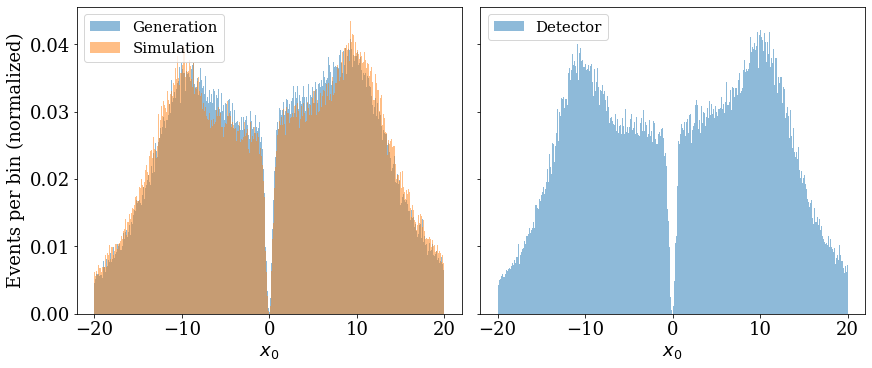

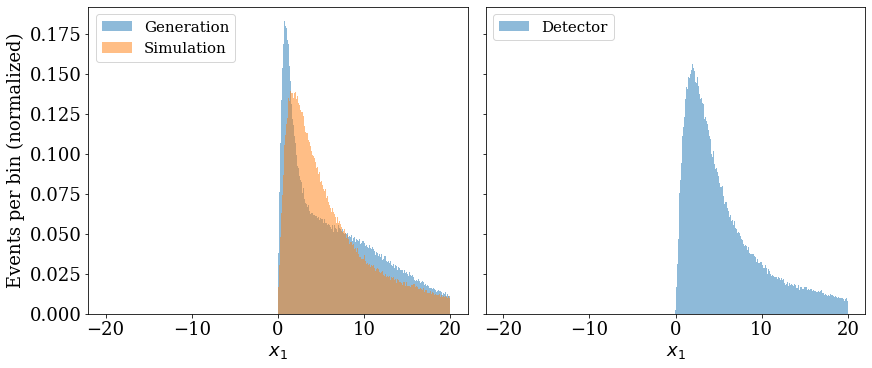

In [37]:
bins = np.linspace(-20,20,400)

fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 5),
                       constrained_layout=True,
                       sharey=True)

ax[0].set_xlabel('$x_0$')
ax[0].set_ylabel('Events per bin (normalized)')
ax[0].hist(theta0_G[theta0_G[:,0]!=-10][:,0], bins=bins, **plot_style_2, label='Generation')
ax[0].hist(theta0_S[theta0_S[:,0]!=-10][:,0], bins=bins, **plot_style_2, label='Simulation')
legend = ax[0].legend(
    loc='upper left',
    frameon=True)
plt.setp(legend.get_title(), multialignment='center')

ax[1].set_xlabel('$x_0$')
ax[1].hist(theta_unknown_S[theta_unknown_S[:,0]!=-10][:,0], bins=bins, **plot_style_2, label='Detector')
legend = ax[1].legend(
    loc='upper left',
    frameon=True)
plt.setp(legend.get_title(), multialignment='center')

fig.show()

#bins = np.linspace(-180,180, 101)
#bins = np.linspace(0,2, 101)
bins = np.linspace(-20,20,400)
fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 5),
                       constrained_layout=True,
                       sharey=True)

ax[0].set_xlabel('$x_1$')
ax[0].set_ylabel('Events per bin (normalized)')
ax[0].hist(theta0_G[theta0_G[:,0]!=-10][:,-1], bins=bins, **plot_style_2, label='Generation')
ax[0].hist(theta0_S[theta0_S[:,0]!=-10][:,-1], bins=bins, **plot_style_2, label='Simulation')
legend = ax[0].legend(
    loc='upper left',
    frameon=True)
plt.setp(legend.get_title(), multialignment='center')

ax[1].set_xlabel('$x_1$')
ax[1].hist(theta_unknown_S[theta_unknown_S[:,0]!=-10][:,-1],bins=bins, **plot_style_2, label='Detector')
legend = ax[1].legend(
    loc='upper left',
    frameon=True)
plt.setp(legend.get_title(), multialignment='center')

fig.show()

## Run unfolding on data

In [38]:
# import tensorflow as tf
# gpus = tf.config.experimental.list_physical_devices('GPU')
# for gpu in gpus:
#     tf.config.experimental.set_memory_growth(gpu, True)

In [39]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.experimental.set_memory_growth(physical_devices[1], True)

In [40]:
%%time 
iterations =5# use ~4 iterations
num_observables= 8
K.clear_session()
weights, _, history = multifold(num_observables=num_observables,
                       iterations=iterations,
                       theta0_G=theta0_G,
                       theta0_S=theta0_S,
                       theta_unknown_S= theta_unknown_S,verbose=1,weights_MC_sim=weights_MC_sim)


ITERATION: 1

STEP 1

Epoch 1/200
98/98 [==============================] - 0s 3ms/step - loss: 0.1655 - accuracy: 0.4132 - val_loss: 0.0373 - val_accuracy: 0.4661
Epoch 2/200
98/98 [==============================] - 0s 2ms/step - loss: 0.0372 - accuracy: 0.4669 - val_loss: 0.0351 - val_accuracy: 0.4661
Epoch 3/200
98/98 [==============================] - 0s 2ms/step - loss: 0.0358 - accuracy: 0.4669 - val_loss: 0.0347 - val_accuracy: 0.4661
Epoch 4/200
98/98 [==============================] - 0s 2ms/step - loss: 0.0351 - accuracy: 0.4670 - val_loss: 0.0344 - val_accuracy: 0.4661
Epoch 5/200
98/98 [==============================] - 0s 2ms/step - loss: 0.0346 - accuracy: 0.4670 - val_loss: 0.0340 - val_accuracy: 0.4661
Epoch 6/200
98/98 [==============================] - 0s 2ms/step - loss: 0.0341 - accuracy: 0.4670 - val_loss: 0.0337 - val_accuracy: 0.4661
Epoch 7/200
98/98 [==============================] - 0s 2ms/step - loss: 0.0337 - accuracy: 0.4670 - val_loss: 0.0333 - val_accurac

98/98 [==============================] - 0s 2ms/step - loss: 0.0326 - accuracy: 0.4670 - val_loss: 0.0325 - val_accuracy: 0.4661
Epoch 59/200
98/98 [==============================] - 0s 2ms/step - loss: 0.0325 - accuracy: 0.4670 - val_loss: 0.0325 - val_accuracy: 0.4661
Epoch 60/200
98/98 [==============================] - 0s 2ms/step - loss: 0.0325 - accuracy: 0.4670 - val_loss: 0.0325 - val_accuracy: 0.4661
Epoch 61/200
98/98 [==============================] - 0s 2ms/step - loss: 0.0325 - accuracy: 0.4670 - val_loss: 0.0325 - val_accuracy: 0.4661
Epoch 62/200
98/98 [==============================] - 0s 2ms/step - loss: 0.0325 - accuracy: 0.4670 - val_loss: 0.0325 - val_accuracy: 0.4661
Epoch 63/200
98/98 [==============================] - 0s 2ms/step - loss: 0.0325 - accuracy: 0.4670 - val_loss: 0.0325 - val_accuracy: 0.4661
Epoch 64/200
98/98 [==============================] - 0s 2ms/step - loss: 0.0325 - accuracy: 0.4670 - val_loss: 0.0325 - val_accuracy: 0.4661
Epoch 65/200
98/98 

Epoch 116/200
98/98 [==============================] - 0s 2ms/step - loss: 0.0325 - accuracy: 0.4670 - val_loss: 0.0324 - val_accuracy: 0.4661
Epoch 117/200
98/98 [==============================] - 0s 2ms/step - loss: 0.0325 - accuracy: 0.4670 - val_loss: 0.0325 - val_accuracy: 0.4661
Epoch 118/200
98/98 [==============================] - 0s 2ms/step - loss: 0.0325 - accuracy: 0.4670 - val_loss: 0.0324 - val_accuracy: 0.4661
Epoch 119/200
98/98 [==============================] - 0s 2ms/step - loss: 0.0325 - accuracy: 0.4670 - val_loss: 0.0325 - val_accuracy: 0.4661
Epoch 120/200
98/98 [==============================] - 0s 2ms/step - loss: 0.0325 - accuracy: 0.4670 - val_loss: 0.0324 - val_accuracy: 0.4661
Epoch 121/200
98/98 [==============================] - 0s 2ms/step - loss: 0.0325 - accuracy: 0.4670 - val_loss: 0.0325 - val_accuracy: 0.4661
Epoch 122/200
98/98 [==============================] - 0s 2ms/step - loss: 0.0325 - accuracy: 0.4670 - val_loss: 0.0324 - val_accuracy: 0.4661

98/98 [==============================] - 0s 2ms/step - loss: 0.0325 - accuracy: 0.4670 - val_loss: 0.0324 - val_accuracy: 0.4661
Epoch 174/200
98/98 [==============================] - 0s 2ms/step - loss: 0.0324 - accuracy: 0.4670 - val_loss: 0.0324 - val_accuracy: 0.4661
Epoch 175/200
98/98 [==============================] - 0s 2ms/step - loss: 0.0325 - accuracy: 0.4670 - val_loss: 0.0324 - val_accuracy: 0.4661
Epoch 176/200
98/98 [==============================] - 0s 2ms/step - loss: 0.0324 - accuracy: 0.4670 - val_loss: 0.0324 - val_accuracy: 0.4661
Epoch 177/200
98/98 [==============================] - 0s 2ms/step - loss: 0.0324 - accuracy: 0.4670 - val_loss: 0.0324 - val_accuracy: 0.4661
Epoch 178/200
98/98 [==============================] - 0s 2ms/step - loss: 0.0324 - accuracy: 0.4670 - val_loss: 0.0324 - val_accuracy: 0.4661
Epoch 179/200
98/98 [==============================] - 0s 2ms/step - loss: 0.0325 - accuracy: 0.4670 - val_loss: 0.0324 - val_accuracy: 0.4661
Epoch 180/200

117/117 [==============================] - 0s 2ms/step - loss: 0.0351 - accuracy: 0.3056 - val_loss: 0.0352 - val_accuracy: 0.3057
Epoch 31/200
117/117 [==============================] - 0s 2ms/step - loss: 0.0351 - accuracy: 0.3056 - val_loss: 0.0352 - val_accuracy: 0.3057
Epoch 32/200
117/117 [==============================] - 0s 2ms/step - loss: 0.0351 - accuracy: 0.3056 - val_loss: 0.0352 - val_accuracy: 0.3057
Epoch 33/200
117/117 [==============================] - 0s 2ms/step - loss: 0.0351 - accuracy: 0.3056 - val_loss: 0.0352 - val_accuracy: 0.3057
Epoch 34/200
117/117 [==============================] - 0s 2ms/step - loss: 0.0351 - accuracy: 0.3056 - val_loss: 0.0352 - val_accuracy: 0.3057
Epoch 35/200
117/117 [==============================] - 0s 2ms/step - loss: 0.0351 - accuracy: 0.3056 - val_loss: 0.0352 - val_accuracy: 0.3057
Epoch 36/200
117/117 [==============================] - 0s 2ms/step - loss: 0.0351 - accuracy: 0.3056 - val_loss: 0.0352 - val_accuracy: 0.3057
Epoch

Epoch 9/200
98/98 [==============================] - 0s 2ms/step - loss: 0.5409 - accuracy: 0.4277 - val_loss: 0.5393 - val_accuracy: 0.4569
Epoch 10/200
98/98 [==============================] - 0s 2ms/step - loss: 0.5410 - accuracy: 0.4296 - val_loss: 0.5389 - val_accuracy: 0.4554
Epoch 11/200
98/98 [==============================] - 0s 2ms/step - loss: 0.5405 - accuracy: 0.4291 - val_loss: 0.5396 - val_accuracy: 0.4642
Epoch 12/200
98/98 [==============================] - 0s 2ms/step - loss: 0.5405 - accuracy: 0.4276 - val_loss: 0.5388 - val_accuracy: 0.4526
Epoch 13/200
98/98 [==============================] - 0s 2ms/step - loss: 0.5406 - accuracy: 0.4271 - val_loss: 0.5389 - val_accuracy: 0.4580
Epoch 14/200
98/98 [==============================] - 0s 2ms/step - loss: 0.5402 - accuracy: 0.4307 - val_loss: 0.5387 - val_accuracy: 0.4196
Epoch 15/200
98/98 [==============================] - 0s 2ms/step - loss: 0.5405 - accuracy: 0.4274 - val_loss: 0.5388 - val_accuracy: 0.4587
Epoch 1

Epoch 67/200
98/98 [==============================] - 0s 2ms/step - loss: 0.5389 - accuracy: 0.4257 - val_loss: 0.5379 - val_accuracy: 0.4122
Epoch 68/200
98/98 [==============================] - 0s 2ms/step - loss: 0.5390 - accuracy: 0.4269 - val_loss: 0.5374 - val_accuracy: 0.4257
Epoch 69/200
98/98 [==============================] - 0s 2ms/step - loss: 0.5390 - accuracy: 0.4275 - val_loss: 0.5375 - val_accuracy: 0.4403
Epoch 70/200
98/98 [==============================] - 0s 2ms/step - loss: 0.5390 - accuracy: 0.4280 - val_loss: 0.5374 - val_accuracy: 0.4264
Epoch 71/200
98/98 [==============================] - 0s 2ms/step - loss: 0.5388 - accuracy: 0.4250 - val_loss: 0.5376 - val_accuracy: 0.4083
Epoch 72/200
98/98 [==============================] - 0s 2ms/step - loss: 0.5388 - accuracy: 0.4238 - val_loss: 0.5377 - val_accuracy: 0.4074
Epoch 73/200
98/98 [==============================] - 0s 2ms/step - loss: 0.5389 - accuracy: 0.4222 - val_loss: 0.5374 - val_accuracy: 0.4285
Epoch 

117/117 [==============================] - 0s 2ms/step - loss: 0.0354 - accuracy: 0.3058 - val_loss: 0.0354 - val_accuracy: 0.3051
Epoch 8/200
117/117 [==============================] - 0s 2ms/step - loss: 0.0353 - accuracy: 0.3058 - val_loss: 0.0354 - val_accuracy: 0.3051
Epoch 9/200
117/117 [==============================] - 0s 2ms/step - loss: 0.0353 - accuracy: 0.3058 - val_loss: 0.0354 - val_accuracy: 0.3051
Epoch 10/200
117/117 [==============================] - 0s 2ms/step - loss: 0.0353 - accuracy: 0.3058 - val_loss: 0.0354 - val_accuracy: 0.3051
Epoch 11/200
117/117 [==============================] - 0s 2ms/step - loss: 0.0353 - accuracy: 0.3058 - val_loss: 0.0354 - val_accuracy: 0.3051
Epoch 12/200
117/117 [==============================] - 0s 2ms/step - loss: 0.0353 - accuracy: 0.3058 - val_loss: 0.0354 - val_accuracy: 0.3051
Epoch 13/200
117/117 [==============================] - 0s 2ms/step - loss: 0.0353 - accuracy: 0.3058 - val_loss: 0.0354 - val_accuracy: 0.3051
Epoch 1

Epoch 64/200
117/117 [==============================] - 0s 2ms/step - loss: 0.0353 - accuracy: 0.3058 - val_loss: 0.0354 - val_accuracy: 0.3051
Epoch 65/200
117/117 [==============================] - 0s 2ms/step - loss: 0.0353 - accuracy: 0.3058 - val_loss: 0.0354 - val_accuracy: 0.3051
Epoch 66/200
117/117 [==============================] - 0s 2ms/step - loss: 0.0353 - accuracy: 0.3058 - val_loss: 0.0353 - val_accuracy: 0.3051
Epoch 67/200
117/117 [==============================] - 0s 2ms/step - loss: 0.0353 - accuracy: 0.3058 - val_loss: 0.0354 - val_accuracy: 0.3051
Epoch 68/200
117/117 [==============================] - 0s 2ms/step - loss: 0.0353 - accuracy: 0.3058 - val_loss: 0.0354 - val_accuracy: 0.3051
Epoch 69/200
117/117 [==============================] - 0s 2ms/step - loss: 0.0353 - accuracy: 0.3058 - val_loss: 0.0354 - val_accuracy: 0.3051
Epoch 70/200
117/117 [==============================] - 0s 2ms/step - loss: 0.0353 - accuracy: 0.3058 - val_loss: 0.0354 - val_accuracy:

Epoch 121/200
117/117 [==============================] - 0s 2ms/step - loss: 0.0353 - accuracy: 0.3058 - val_loss: 0.0354 - val_accuracy: 0.3051
Epoch 122/200
117/117 [==============================] - 0s 2ms/step - loss: 0.0353 - accuracy: 0.3058 - val_loss: 0.0354 - val_accuracy: 0.3051
Epoch 123/200
117/117 [==============================] - 0s 2ms/step - loss: 0.0353 - accuracy: 0.3058 - val_loss: 0.0354 - val_accuracy: 0.3051
Epoch 124/200
117/117 [==============================] - 0s 2ms/step - loss: 0.0353 - accuracy: 0.3058 - val_loss: 0.0354 - val_accuracy: 0.3051
Epoch 125/200
117/117 [==============================] - 0s 2ms/step - loss: 0.0353 - accuracy: 0.3058 - val_loss: 0.0354 - val_accuracy: 0.3051
Epoch 126/200
117/117 [==============================] - 0s 2ms/step - loss: 0.0353 - accuracy: 0.3058 - val_loss: 0.0354 - val_accuracy: 0.3051
Epoch 127/200
117/117 [==============================] - 0s 2ms/step - loss: 0.0353 - accuracy: 0.3058 - val_loss: 0.0354 - val_ac

98/98 [==============================] - 0s 2ms/step - loss: 0.5581 - accuracy: 0.3914 - val_loss: 0.5583 - val_accuracy: 0.4103
Epoch 48/200
98/98 [==============================] - 0s 2ms/step - loss: 0.5579 - accuracy: 0.3965 - val_loss: 0.5583 - val_accuracy: 0.3767
Epoch 49/200
98/98 [==============================] - 0s 2ms/step - loss: 0.5580 - accuracy: 0.3902 - val_loss: 0.5585 - val_accuracy: 0.4203
Epoch 50/200
98/98 [==============================] - 0s 2ms/step - loss: 0.5580 - accuracy: 0.3961 - val_loss: 0.5587 - val_accuracy: 0.4226
Epoch 51/200
98/98 [==============================] - 0s 2ms/step - loss: 0.5578 - accuracy: 0.3936 - val_loss: 0.5584 - val_accuracy: 0.3672
Epoch 52/200
98/98 [==============================] - 0s 2ms/step - loss: 0.5578 - accuracy: 0.3944 - val_loss: 0.5583 - val_accuracy: 0.3971
Epoch 53/200
98/98 [==============================] - 0s 2ms/step - loss: 0.5579 - accuracy: 0.3944 - val_loss: 0.5584 - val_accuracy: 0.4042
Epoch 54/200
98/98 

Epoch 105/200
98/98 [==============================] - 0s 2ms/step - loss: 0.5574 - accuracy: 0.3990 - val_loss: 0.5582 - val_accuracy: 0.4164
Epoch 106/200
98/98 [==============================] - 0s 2ms/step - loss: 0.5574 - accuracy: 0.3983 - val_loss: 0.5584 - val_accuracy: 0.3668
Epoch 107/200
98/98 [==============================] - 0s 2ms/step - loss: 0.5574 - accuracy: 0.3947 - val_loss: 0.5581 - val_accuracy: 0.3955
Epoch 108/200
98/98 [==============================] - 0s 2ms/step - loss: 0.5576 - accuracy: 0.3999 - val_loss: 0.5581 - val_accuracy: 0.3948
Epoch 109/200
98/98 [==============================] - 0s 2ms/step - loss: 0.5574 - accuracy: 0.3948 - val_loss: 0.5592 - val_accuracy: 0.3406
Epoch 110/200
98/98 [==============================] - 0s 2ms/step - loss: 0.5577 - accuracy: 0.3918 - val_loss: 0.5583 - val_accuracy: 0.3767
Epoch 111/200
98/98 [==============================] - 0s 2ms/step - loss: 0.5574 - accuracy: 0.3943 - val_loss: 0.5585 - val_accuracy: 0.4271

Epoch 43/200
117/117 [==============================] - 0s 2ms/step - loss: 0.0353 - accuracy: 0.3054 - val_loss: 0.0352 - val_accuracy: 0.3064
Epoch 44/200
117/117 [==============================] - 0s 2ms/step - loss: 0.0353 - accuracy: 0.3054 - val_loss: 0.0352 - val_accuracy: 0.3064
Epoch 45/200
117/117 [==============================] - 0s 2ms/step - loss: 0.0353 - accuracy: 0.3054 - val_loss: 0.0352 - val_accuracy: 0.3064
Epoch 46/200
117/117 [==============================] - 0s 2ms/step - loss: 0.0353 - accuracy: 0.3054 - val_loss: 0.0352 - val_accuracy: 0.3064
Epoch 47/200
117/117 [==============================] - 0s 2ms/step - loss: 0.0353 - accuracy: 0.3054 - val_loss: 0.0352 - val_accuracy: 0.3064
Epoch 48/200
117/117 [==============================] - 0s 2ms/step - loss: 0.0353 - accuracy: 0.3054 - val_loss: 0.0352 - val_accuracy: 0.3064
Epoch 49/200
117/117 [==============================] - 0s 2ms/step - loss: 0.0353 - accuracy: 0.3054 - val_loss: 0.0352 - val_accuracy:

Epoch 17/200
98/98 [==============================] - 0s 2ms/step - loss: 0.5512 - accuracy: 0.4046 - val_loss: 0.5518 - val_accuracy: 0.3412
Epoch 18/200
98/98 [==============================] - 0s 2ms/step - loss: 0.5513 - accuracy: 0.4022 - val_loss: 0.5507 - val_accuracy: 0.4330
Epoch 19/200
98/98 [==============================] - 0s 2ms/step - loss: 0.5513 - accuracy: 0.4073 - val_loss: 0.5505 - val_accuracy: 0.4127
Epoch 20/200
98/98 [==============================] - 0s 2ms/step - loss: 0.5512 - accuracy: 0.4054 - val_loss: 0.5505 - val_accuracy: 0.3939
Epoch 21/200
98/98 [==============================] - 0s 2ms/step - loss: 0.5511 - accuracy: 0.4038 - val_loss: 0.5506 - val_accuracy: 0.3838
Epoch 22/200
98/98 [==============================] - 0s 2ms/step - loss: 0.5511 - accuracy: 0.4050 - val_loss: 0.5505 - val_accuracy: 0.3804
Epoch 23/200
98/98 [==============================] - 0s 2ms/step - loss: 0.5509 - accuracy: 0.4046 - val_loss: 0.5506 - val_accuracy: 0.4271
Epoch 

Epoch 75/200
98/98 [==============================] - 0s 2ms/step - loss: 0.5506 - accuracy: 0.4053 - val_loss: 0.5507 - val_accuracy: 0.3991
Epoch 76/200
98/98 [==============================] - 0s 2ms/step - loss: 0.5511 - accuracy: 0.3980 - val_loss: 0.5510 - val_accuracy: 0.3816
Epoch 77/200
98/98 [==============================] - 0s 2ms/step - loss: 0.5507 - accuracy: 0.4055 - val_loss: 0.5506 - val_accuracy: 0.3963
Epoch 78/200
98/98 [==============================] - 0s 2ms/step - loss: 0.5506 - accuracy: 0.4076 - val_loss: 0.5505 - val_accuracy: 0.4133
Epoch 79/200
98/98 [==============================] - 0s 2ms/step - loss: 0.5509 - accuracy: 0.4082 - val_loss: 0.5506 - val_accuracy: 0.3907
Epoch 80/200
98/98 [==============================] - 0s 2ms/step - loss: 0.5508 - accuracy: 0.4007 - val_loss: 0.5508 - val_accuracy: 0.3810
Epoch 81/200
98/98 [==============================] - 0s 2ms/step - loss: 0.5505 - accuracy: 0.4044 - val_loss: 0.5504 - val_accuracy: 0.4141
Epoch 

Epoch 41/200
117/117 [==============================] - 0s 2ms/step - loss: 0.0353 - accuracy: 0.3056 - val_loss: 0.0354 - val_accuracy: 0.3056
Epoch 42/200
117/117 [==============================] - 0s 2ms/step - loss: 0.0353 - accuracy: 0.3056 - val_loss: 0.0354 - val_accuracy: 0.3056
Epoch 43/200
117/117 [==============================] - 0s 2ms/step - loss: 0.0353 - accuracy: 0.3056 - val_loss: 0.0354 - val_accuracy: 0.3056
Epoch 44/200
117/117 [==============================] - 0s 2ms/step - loss: 0.0353 - accuracy: 0.3056 - val_loss: 0.0354 - val_accuracy: 0.3056
Epoch 45/200
117/117 [==============================] - 0s 2ms/step - loss: 0.0353 - accuracy: 0.3056 - val_loss: 0.0354 - val_accuracy: 0.3056
Epoch 46/200
117/117 [==============================] - 0s 2ms/step - loss: 0.0353 - accuracy: 0.3056 - val_loss: 0.0354 - val_accuracy: 0.3056
Epoch 47/200
117/117 [==============================] - 0s 2ms/step - loss: 0.0353 - accuracy: 0.3056 - val_loss: 0.0354 - val_accuracy:

Epoch 24/200
98/98 [==============================] - 0s 2ms/step - loss: 0.5615 - accuracy: 0.3862 - val_loss: 0.5610 - val_accuracy: 0.3959
Epoch 25/200
98/98 [==============================] - 0s 2ms/step - loss: 0.5614 - accuracy: 0.3874 - val_loss: 0.5610 - val_accuracy: 0.3567
Epoch 26/200
98/98 [==============================] - 0s 2ms/step - loss: 0.5614 - accuracy: 0.3839 - val_loss: 0.5611 - val_accuracy: 0.4158
Epoch 27/200
98/98 [==============================] - 0s 2ms/step - loss: 0.5614 - accuracy: 0.3881 - val_loss: 0.5615 - val_accuracy: 0.4357
Epoch 28/200
98/98 [==============================] - 0s 2ms/step - loss: 0.5616 - accuracy: 0.3884 - val_loss: 0.5613 - val_accuracy: 0.4205
Epoch 29/200
98/98 [==============================] - 0s 2ms/step - loss: 0.5617 - accuracy: 0.3891 - val_loss: 0.5614 - val_accuracy: 0.3382
Epoch 30/200
98/98 [==============================] - 0s 2ms/step - loss: 0.5617 - accuracy: 0.3805 - val_loss: 0.5613 - val_accuracy: 0.4154
Epoch 

Epoch 82/200
98/98 [==============================] - 0s 2ms/step - loss: 0.5609 - accuracy: 0.3850 - val_loss: 0.5614 - val_accuracy: 0.3421
Epoch 83/200
98/98 [==============================] - 0s 2ms/step - loss: 0.5611 - accuracy: 0.3868 - val_loss: 0.5612 - val_accuracy: 0.3507
Epoch 84/200
98/98 [==============================] - 0s 2ms/step - loss: 0.5610 - accuracy: 0.3876 - val_loss: 0.5607 - val_accuracy: 0.3693
Epoch 85/200
98/98 [==============================] - 0s 2ms/step - loss: 0.5609 - accuracy: 0.3846 - val_loss: 0.5611 - val_accuracy: 0.4218
Epoch 86/200
98/98 [==============================] - 0s 2ms/step - loss: 0.5609 - accuracy: 0.3904 - val_loss: 0.5608 - val_accuracy: 0.3658
Epoch 87/200
98/98 [==============================] - 0s 2ms/step - loss: 0.5609 - accuracy: 0.3845 - val_loss: 0.5609 - val_accuracy: 0.4133
Epoch 88/200
98/98 [==============================] - 0s 2ms/step - loss: 0.5611 - accuracy: 0.3901 - val_loss: 0.5612 - val_accuracy: 0.3465
Epoch 

Epoch 40/200
117/117 [==============================] - 0s 2ms/step - loss: 0.0352 - accuracy: 0.3057 - val_loss: 0.0352 - val_accuracy: 0.3054
Epoch 41/200
117/117 [==============================] - 0s 2ms/step - loss: 0.0352 - accuracy: 0.3057 - val_loss: 0.0352 - val_accuracy: 0.3054
Epoch 42/200
117/117 [==============================] - 0s 2ms/step - loss: 0.0352 - accuracy: 0.3057 - val_loss: 0.0352 - val_accuracy: 0.3054
Epoch 43/200
117/117 [==============================] - 0s 2ms/step - loss: 0.0352 - accuracy: 0.3057 - val_loss: 0.0352 - val_accuracy: 0.3054
Epoch 44/200
117/117 [==============================] - 0s 2ms/step - loss: 0.0352 - accuracy: 0.3057 - val_loss: 0.0352 - val_accuracy: 0.3054
Epoch 45/200
117/117 [==============================] - 0s 2ms/step - loss: 0.0352 - accuracy: 0.3057 - val_loss: 0.0352 - val_accuracy: 0.3054
Epoch 46/200
117/117 [==============================] - 0s 2ms/step - loss: 0.0352 - accuracy: 0.3057 - val_loss: 0.0352 - val_accuracy:

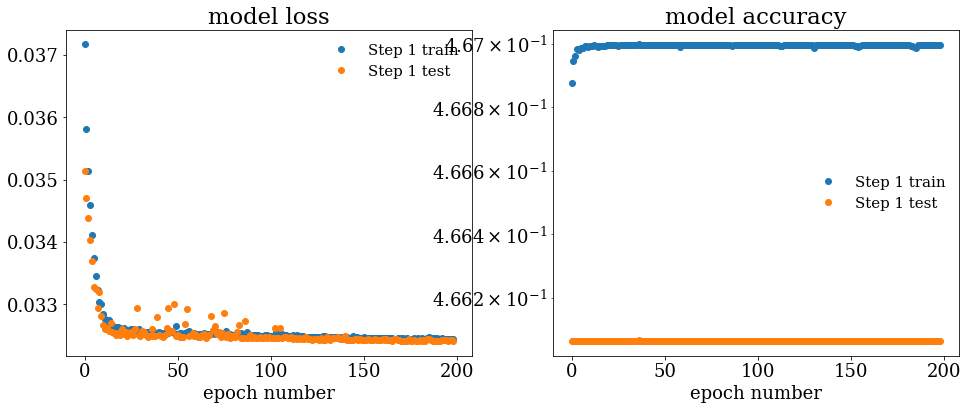

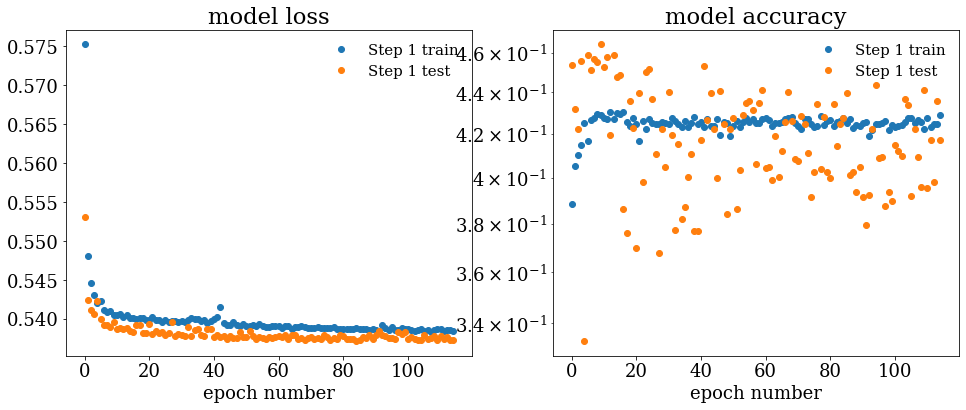

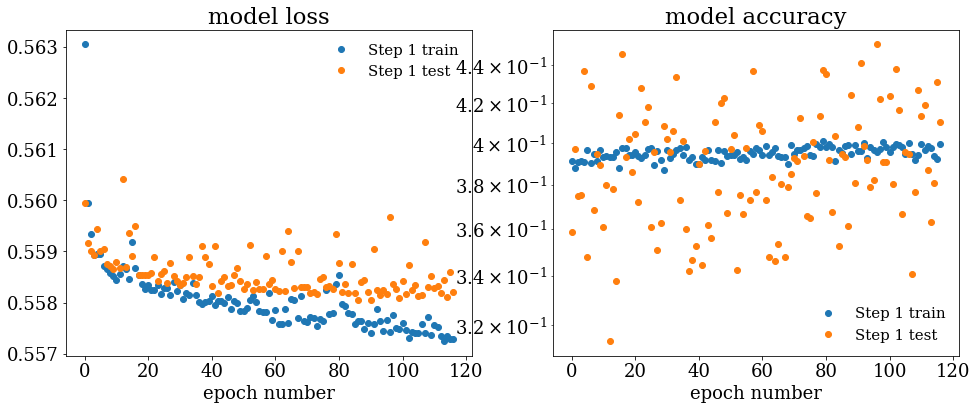

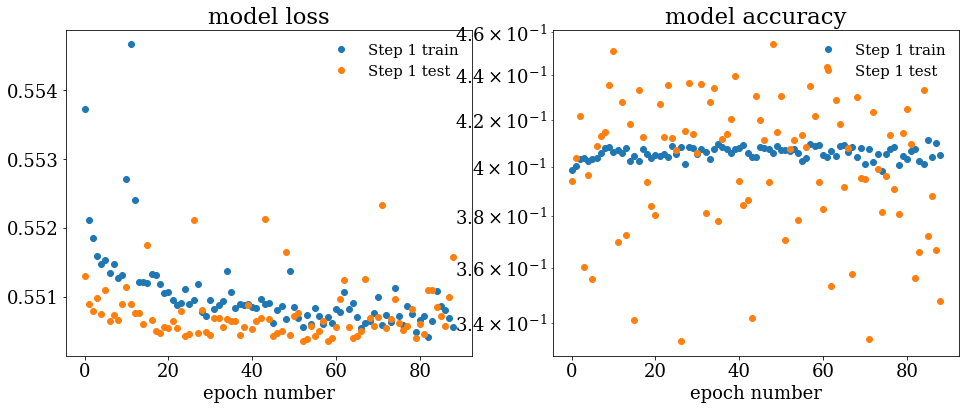

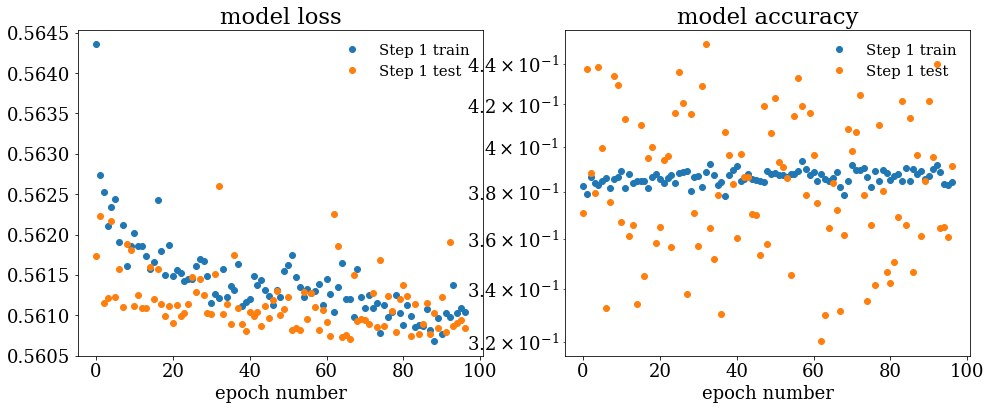

In [41]:
#list all data in history
# summarize history for accuracy
for i in range(iterations):
    fig,ax = plt.subplots(1,2,figsize=(16,6))
    ax[0].set_title('model loss')
    ax[0].set_xlabel('epoch number')
    ax[0].plot(history['step1'][i].history['loss'][1:],'o',label='Step 1 train')
    ax[0].plot(history['step1'][i].history['val_loss'][1:],'o',label='Step 1 test')

    ax[1].set_title('model accuracy')
    ax[1].plot(history['step1'][i].history['accuracy'][1:],'o',label='Step 1 train')
    ax[1].plot(history['step1'][i].history['val_accuracy'][1:],'o',label='Step 1 test')
    ax[1].legend()
    ax[1].set_xlabel('epoch number')
    ax[1].set_yscale('log')
    ax[0].legend()

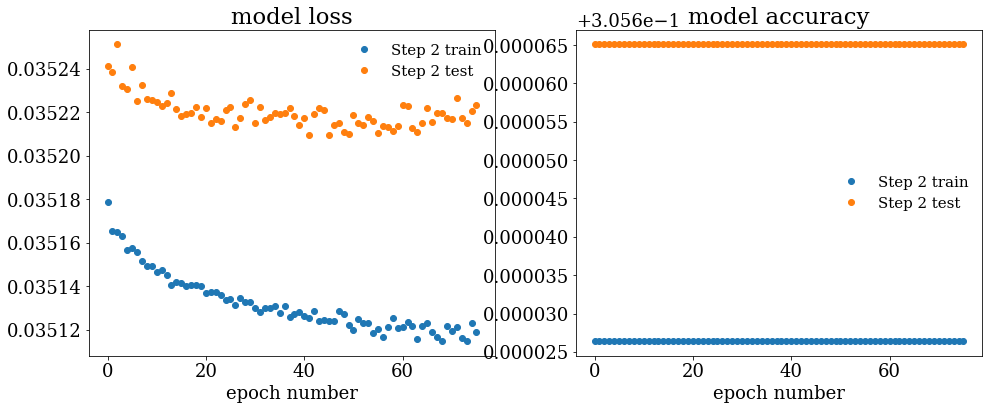

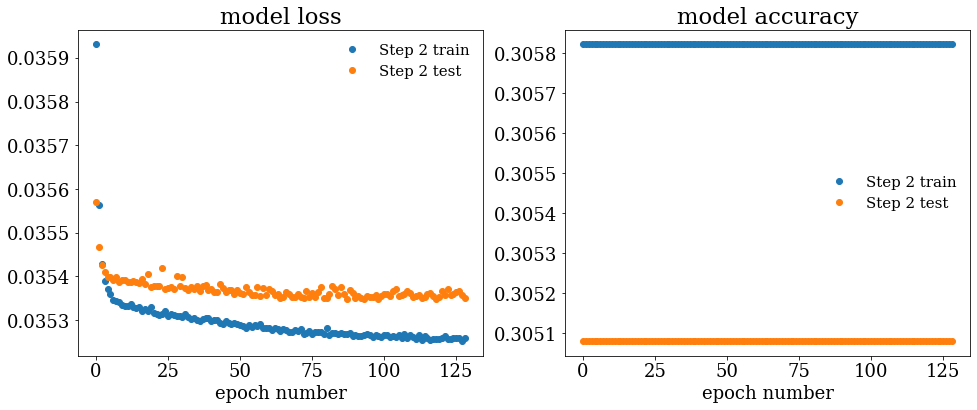

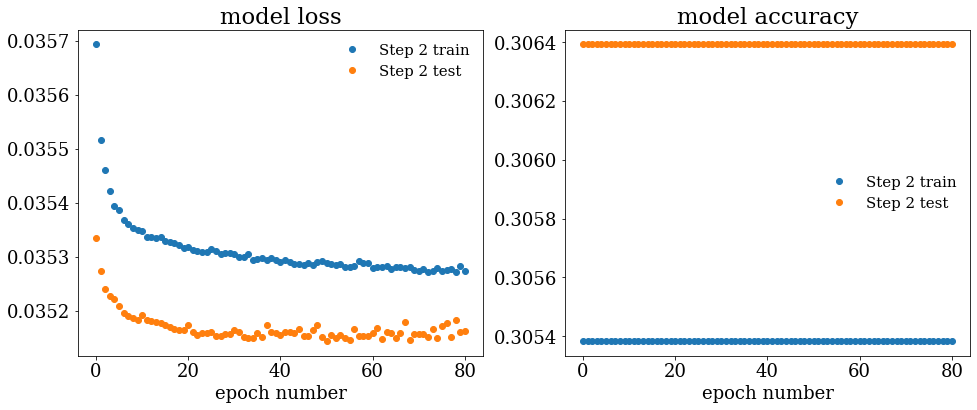

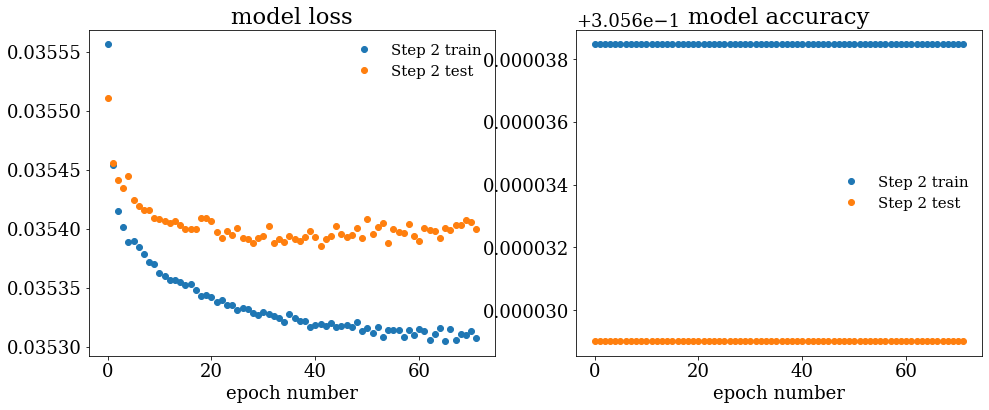

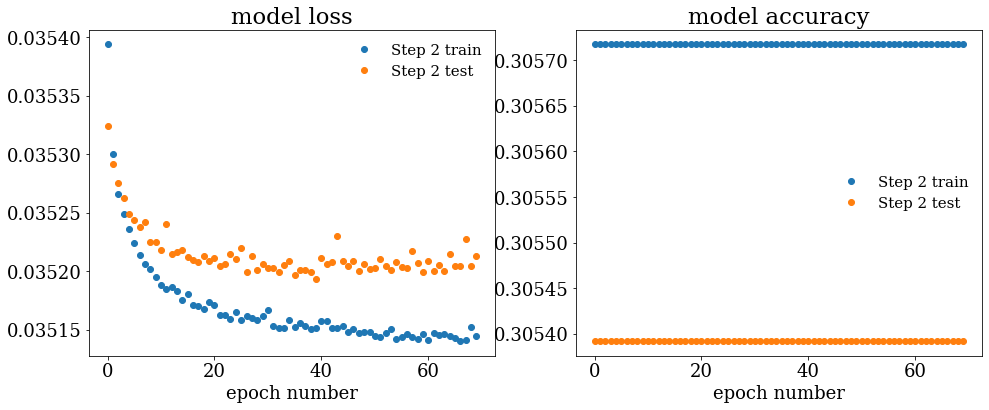

In [42]:
for i in range(iterations):
    fig,ax = plt.subplots(1,2,figsize=(16,6))
    ax[0].set_title('model loss')
    ax[0].set_xlabel('epoch number')
    ax[0].plot(history['step2'][i].history['loss'][1:],'o',label='Step 2 train')
    ax[0].plot(history['step2'][i].history['val_loss'][1:],'o',label='Step 2 test')

    ax[1].set_title('model accuracy')
    ax[1].plot(history['step2'][i].history['accuracy'][1:],'o',label='Step 2 train')
    ax[1].plot(history['step2'][i].history['val_accuracy'][1:],'o',label='Step 2 test')
    ax[1].legend()
    ax[1].set_xlabel('epoch number')

    ax[0].legend()

## Incorporate weights into the dataframe

In [43]:
mc_cut['weight_reco'] =  weights[-2, 0, :]
mc_cut['weight_truth'] = weights[-2, 1, :]

<ipython-input-43-afc8f285f76b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mc_cut['weight_reco'] =  weights[-2, 0, :]
<ipython-input-43-afc8f285f76b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mc_cut['weight_truth'] = weights[-2, 1, :]


In [44]:
mc_cut['weight_reco_next'] = weights[-1, 0, :]
mc_cut['weight_truth_next'] = weights[-1, 1, :]

mc_cut['weight_reco_previous'] =  weights[-3, 0, :]
mc_cut['weight_truth_previous'] = weights[-3, 1, :]


<ipython-input-44-ae014266c17d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mc_cut['weight_reco_next'] = weights[-1, 0, :]
<ipython-input-44-ae014266c17d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mc_cut['weight_truth_next'] = weights[-1, 1, :]
<ipython-input-44-ae014266c17d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-doc

## Check weights

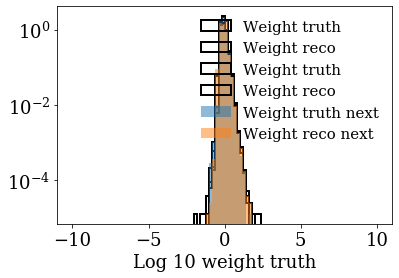

In [45]:
plt.hist(np.log10(mc_cut['weight_truth']),range=(-10,10),bins=100,**plot_style_1,label='Weight truth')
plt.hist(np.log10(mc_cut['weight_reco']),range=(-10,10),bins=100,**plot_style_1, label='Weight reco')

plt.hist(np.log10(mc_cut['weight_truth_previous']),range=(-10,10),bins=100,**plot_style_1,label='Weight truth')
plt.hist(np.log10(mc_cut['weight_reco_previous']),range=(-10,10),bins=100,**plot_style_1, label='Weight reco')

plt.hist(np.log10(mc_cut['weight_truth_next']),range=(-10,10),bins=100,**plot_style_2,label='Weight truth next')
plt.hist(np.log10(mc_cut['weight_reco_next']),range=(-10,10),bins=100,**plot_style_2, label='Weight reco next')
plt.legend()
plt.xlabel('Log 10 weight truth')
plt.yscale('log')
plt.show()

#for i in range(len(weights)):
    #print ('Iteration %i'%i)
    #print(max(weights[i, 1, :]), min(weights[i, 1, :]))    
    #print(max(weights[i, 0, :]), min(weights[i, 0, :]))
    #print(' ')

In [46]:
print(len(mc_cut))

mc_cut = mc_cut.query('weight_reco<1e4 and weight_reco>1e-3')
mc_cut = mc_cut.query('weight_truth<1e4 and weight_truth>1e-3')
print(len(mc_cut))

388026
388026


In [47]:
mc_cut = mc_cut.query('weight_reco_next<1e3 and weight_reco_next>1e-3')
mc_cut = mc_cut.query('weight_truth_next<1e3 and weight_truth_next>1e-3')

mc_cut = mc_cut.query('weight_reco_previous<1e3 and weight_reco_previous>1e-3')
mc_cut = mc_cut.query('weight_truth_previous<1e3 and weight_truth_previous>1e-3')

ITERATION: 1
ITERATION: 2
ITERATION: 3
ITERATION: 4
ITERATION: 5


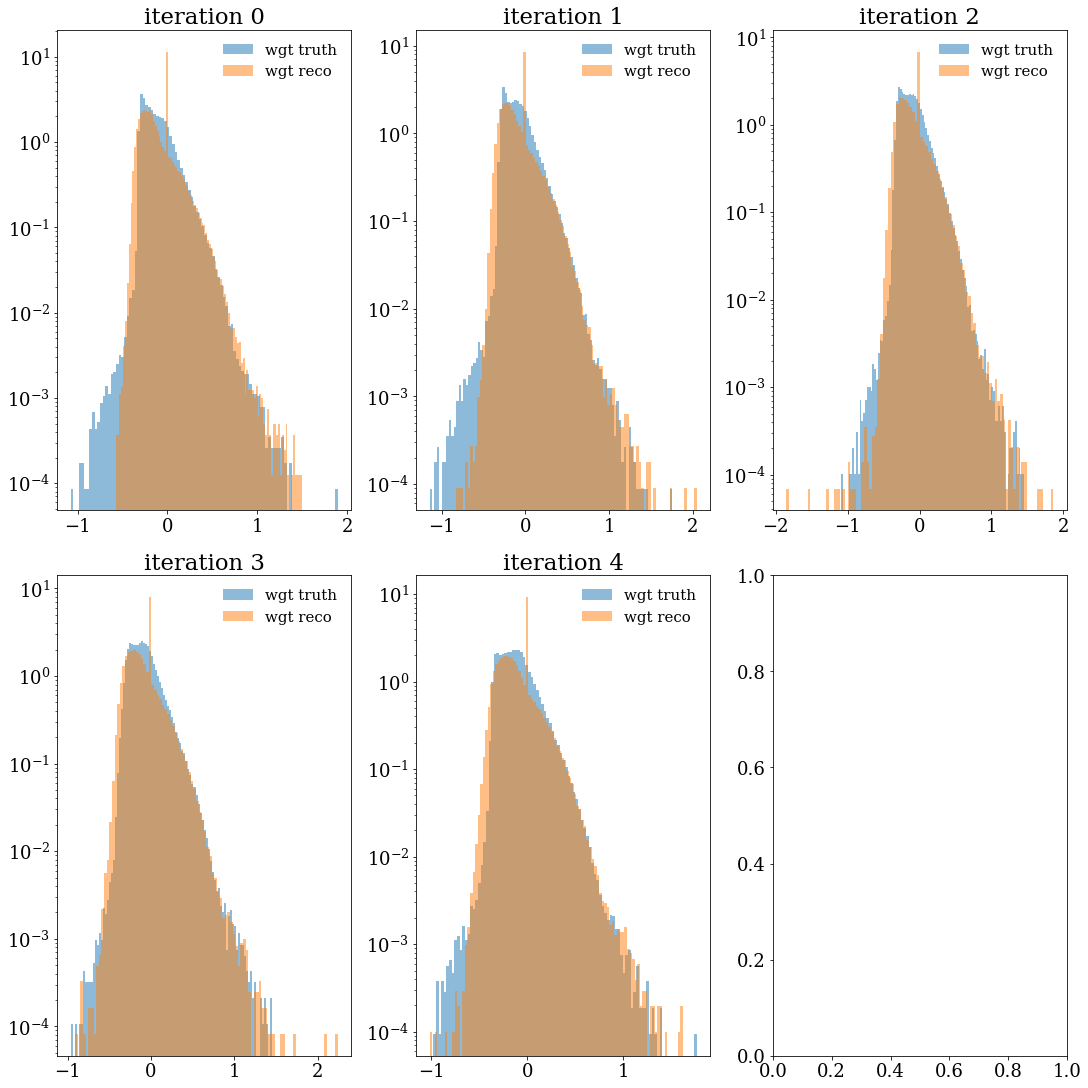

In [48]:
fig, ax = plt.subplots(2,
                           3,
                           figsize=(15, 15),
                           constrained_layout=True)
ax = ax.flatten()
for i in range(len(weights)):

    print("ITERATION: {}".format(i + 1))
    #bins = np.linspace(5, 50, 45)
    
    
    ax[i].hist(np.log10(weights[i, 1, :][~np.isnan(weights[i, 1, :])]),bins=100,**plot_style_2,label='wgt truth')
    ax[i].hist(np.log10(weights[i, 0, :][~np.isnan(weights[i, 0, :])]),bins=100,**plot_style_2, label='wgt reco') 
    ax[i].legend()
    ax[i].set_yscale('log')
    ax[i].set_title('iteration %i'%i)

    #ax[i].xlabel('Log 10 weight truth')

## Incorporate weights into the dataframe

In [49]:
mc_cut.keys()

Index(['jet_pt', 'jet_phi', 'jet_eta', 'jet_dphi', 'jet_z', 'genjet_pt',
       'genjet_phi', 'genjet_eta', 'genjet_z', 'Q2', 'gen_Q2', 'y', 'gen_y',
       'e_px', 'e_py', 'e_pz', 'gene_px', 'gene_py', 'gene_pz', 'wgt',
       'vertex_z', 'ptmiss', 'ptratio_da', 'ptratio_ele', 'Empz', 'pth',
       'pass_reco', 'pass_truth', 'jet_px', 'jet_py', 'jet_pz', 'jet_qt',
       'jet_qtnorm', 'e_pt', 'e_phi', 'qt_px', 'qt_py', 'qt_phi', 'qt_dot_ept',
       'qt_dphi', 'qt_cos2phi', 'logQ2', 'Q', 'pthoverpte', 'gen_logQ2',
       'gen_Q', 'gene_pt', 'genjet_px', 'genjet_py', 'genjet_pz', 'genjet_qt',
       'genjet_qtnorm', 'gene_phi', 'genjet_dphi', 'genqt_px', 'genqt_py',
       'genqt_phi', 'genqt_dot_ept', 'genqt_dphi', 'genqt_cos2phi',
       'weight_reco', 'weight_truth', 'weight_reco_next', 'weight_truth_next',
       'weight_reco_previous', 'weight_truth_previous'],
      dtype='object')

## MC at reco level reweighted vs data

The query is: pass_reco==1 
ITERATION: 4


<ipython-input-50-b435afe478ac>:134: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


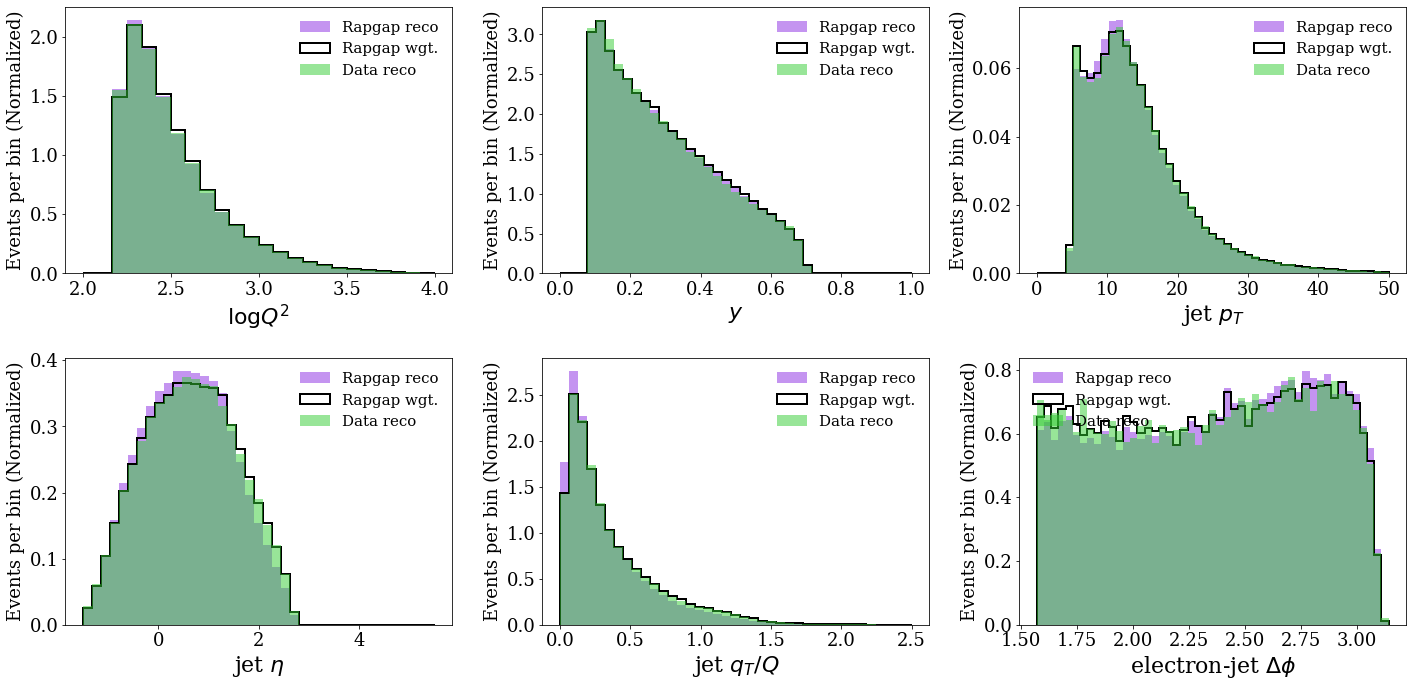

In [50]:
query = 'pass_reco==1 '
print('The query is:' , query)
label1 = mc_name +' reco'
label2 = mc_name +' wgt.'
label3 = 'Data reco'

color1='blueviolet'
color2='limegreen'
#color1='red'
#color2='blue'
for i in range(iterations-2,iterations-1):
    #if(i<2): continue

    print("ITERATION: {}".format(i + 1))
    bins = np.linspace(2, 5,100 )
    fig, ax = plt.subplots(2,
                           3,
                           figsize=(20, 10),
                           constrained_layout=True)
    bins = np.linspace(0.0, 1.0,40 )
    
    ax = ax.flatten()

    ax[1].set_xlabel(r'$y$',fontsize=22)
    ax[1].set_ylabel('Events per bin (Normalized)')
    ax[1].hist(mc_cut.query(query)['y'],bins=bins, weights= mc_cut.query(query)['wgt'],label=label1, **plot_style_2,color=color1)
    ax[1].hist(mc_cut.query(query)['y'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[1].hist(data_cut.query(query)['y'],
               bins=bins,
               label=label3,
               **plot_style_2,color=color2)
    
    ax[1].legend(frameon=False,loc='best')

    bins = np.linspace(2, 4,25 )

    ax[0].set_xlabel(r'$\log Q^{2}$',fontsize=22)
    ax[0].set_ylabel('Events per bin (Normalized)')
    ax[0].hist(mc_cut.query(query)['logQ2'], weights= mc_cut.query(query)['wgt'],bins=bins, label=label1, **plot_style_2,color=color1)
    ax[0].hist(mc_cut.query(query)['logQ2'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[0].hist(data_cut.query(query)['logQ2'],
               bins=bins,
               label=label3,
               **plot_style_2,color=color2)
    
    ax[0].legend(frameon=False,loc='best')

    
    bins = np.linspace(0,50,50 )

    ax[2].set_xlabel('jet $p_{T}$',fontsize=22)
    ax[2].set_ylabel('Events per bin (Normalized)')
    ax[2].hist(mc_cut.query(query)['jet_pt'], weights= mc_cut.query(query)['wgt'],bins=bins, label=label1, **plot_style_2,color=color1)
    ax[2].hist(mc_cut.query(query)['jet_pt'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[2].hist(data_cut.query(query)['jet_pt'],
               bins=bins,
               label=label3,
               **plot_style_2,color=color2)
    #ax[0,2].set_yscale('log')
    #ax[0,2].set_xscale('log')
    ax[2].legend(frameon=False,loc='best')

    
    bins = np.linspace(-1.5,5.5,40 )

    ax[3].set_xlabel('jet $\eta $',fontsize=22)
    ax[3].set_ylabel('Events per bin (Normalized)')
    ax[3].hist(mc_cut.query(query)['jet_eta'],weights= mc_cut.query(query)['wgt'], bins=bins, label=label1, **plot_style_2,color=color1)
    ax[3].hist(mc_cut.query(query)['jet_eta'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[3].hist(data_cut.query(query)['jet_eta'],
               bins=bins,
               label=label3,
               **plot_style_2,color=color2)
    ax[3].legend(frameon=False,loc='best')
    

    bins = np.linspace(0,2.5,40)
    
    ax[4].set_xlabel('jet $q_{T}/Q $',fontsize=22)
    ax[4].set_ylabel('Events per bin (Normalized)')
    ax[4].hist(mc_cut.query(query)['jet_qtnorm'],weights= mc_cut.query(query)['wgt'], bins=bins, label=label1, **plot_style_2,color=color1)
    ax[4].hist(mc_cut.query(query)['jet_qtnorm'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[4].hist(data_cut.query(query)['jet_qtnorm'],
               bins=bins,
               label=label3,
               **plot_style_2,color=color2)
    
    ax[4].legend(frameon=False,loc='best')


    bins = np.linspace(np.pi/2.0,np.pi,50)

    ax[5].set_xlabel(r'electron-jet $\Delta\phi$',fontsize=22)
    ax[5].set_ylabel('Events per bin (Normalized)')
    ax[5].hist(mc_cut.query(query)['jet_dphi'],weights= mc_cut.query(query)['wgt'], bins=bins, label=label1, **plot_style_2,color=color1)
    ax[5].hist(mc_cut.query(query)['jet_dphi'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[5].hist(data_cut.query(query)['jet_dphi'],
               bins=bins,
               label=label3,
               **plot_style_2,color=color2)
    ax[5].legend(frameon=False,loc='best')
    #ax[7].set_yscale('log')
    
    plt.tight_layout()
    fig.savefig('figures/RealDataMC_comparison_inclusivejet_%i_iter_%s_%s_%s_data_%s.png'%(i,mc_name,mc_tag,period,data_tag)) 
    
    

## Plot unfolded results

ITERATION: 4


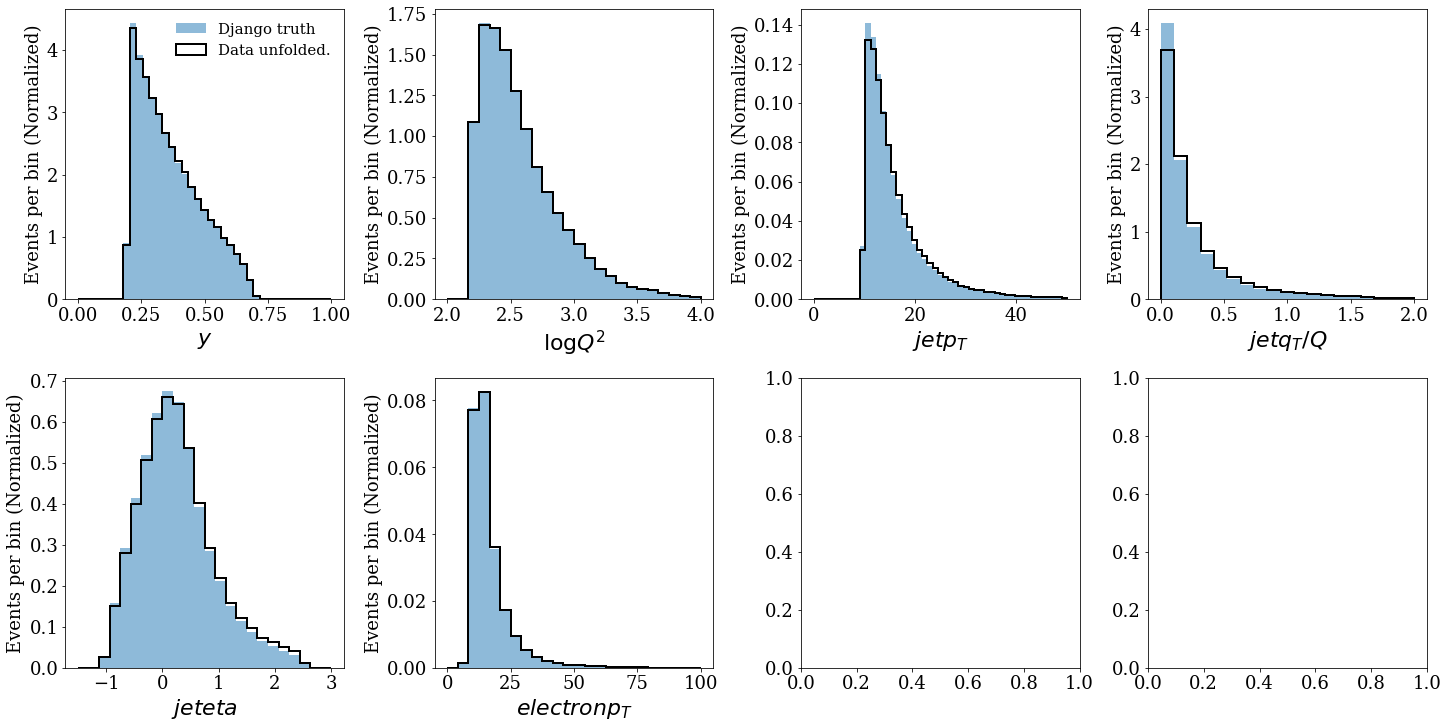

In [51]:
event_selection = 'gen_y>0.2 and gen_y<0.7 and gen_Q2>150'
# ##track_selection = 'gen_track_pt>0.2'
jet_selection    = 'genjet_pt>10 and genjet_eta<2.5 and genjet_eta>-1.0'
query = 'pass_reco==1 and ' + event_selection + ' and ' + jet_selection

label1 = r'Django truth'
label2 = r'Data unfolded.'
label3 = r'Data reco'

#for i in range(len(weights)):
for i in range(iterations-2,iterations-1):

    #if(i<2): continue

    print("ITERATION: {}".format(i + 1))
    bins = np.linspace(2, 5,100 )
    #bins = np.linspace(5, 50, 45)

    fig, ax = plt.subplots(2,
                           4,
                           figsize=(20, 10),
                           constrained_layout=True)
    bins = np.linspace(0.0, 1.0,40 )
    ax = ax.flatten()
    ax[0].set_xlabel(r'$y$',fontsize=22)
    ax[0].set_ylabel('Events per bin (Normalized)')
    ax[0].hist(mc_cut.query(query)['gen_y'], weights = mc_cut.query(query)['wgt'], bins=bins, label=label1, **plot_style_2)
    ax[0].hist(mc_cut.query(query)['gen_y'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)



    
    ax[0].legend(frameon=False)

    bins = np.linspace(2, 4,25 )

    ax[1].set_xlabel(r'$\log Q^{2}$',fontsize=22)
    ax[1].set_ylabel('Events per bin (Normalized)')
    ax[1].hist(mc_cut.query(query)['gen_logQ2'],weights = mc_cut.query(query)['wgt'], bins=bins, label=label1, **plot_style_2)
    ax[1].hist(mc_cut.query(query)['gen_logQ2'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    

    
    bins = np.linspace(0,50,50 )

    ax[2].set_xlabel(r'$jet p_{T} $',fontsize=22)
    ax[2].set_ylabel('Events per bin (Normalized)')
    ax[2].hist(mc_cut.query(query)['genjet_pt'], weights = mc_cut.query(query)['wgt'], bins=bins, label=label1, **plot_style_2)
    ax[2].hist(mc_cut.query(query)['genjet_pt'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)


    bins = np.linspace(0,2,20 )

    
    ax[3].set_xlabel(r'$jet q_{T}/Q $',fontsize=22)
    ax[3].set_ylabel('Events per bin (Normalized)')
    ax[3].hist(mc_cut.query(query)['genjet_qtnorm'], weights = mc_cut.query(query)['wgt'], bins=bins, label=label1, **plot_style_2)
    ax[3].hist(mc_cut.query(query)['genjet_qtnorm'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)


    bins = np.linspace(-1.5,3,25 )

    ax[4].set_xlabel(r'$jet eta $',fontsize=22)
    ax[4].set_ylabel('Events per bin (Normalized)')
    ax[4].hist(mc_cut.query(query)['genjet_eta'], weights = mc_cut.query(query)['wgt'], bins=bins, label=label1, **plot_style_2)
    ax[4].hist(mc_cut.query(query)['genjet_eta'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    
    bins = np.linspace(0,100,25)

    ax[5].set_xlabel(r'$electron p_{T} $',fontsize=22)
    ax[5].set_ylabel('Events per bin (Normalized)')
    ax[5].hist(mc_cut.query(query)['gene_pt'], weights = mc_cut.query(query)['wgt'],bins=bins, label=label1, **plot_style_2)
    ax[5].hist(mc_cut.query(query)['gene_pt'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    

## define binning

In [52]:
qtbins = np.logspace(np.log10(0.03),np.log10(3.03),9) - 0.03
qtbins[0] = 0.0
print (qtbins)

[0.         0.02341478 0.06510462 0.13933307 0.27149627 0.50681187
 0.92578957 1.67177624 3.        ]


In [53]:
np.logspace(np.log10(1e-10),np.log10(3),9) 

array([1.00000000e-10, 2.04004692e-09, 4.16179145e-08, 8.49024984e-07,
       1.73205081e-05, 3.53346492e-04, 7.20843424e-03, 1.47055441e-01,
       3.00000000e+00])

## Jet pT spectrum data reco vs MC reco

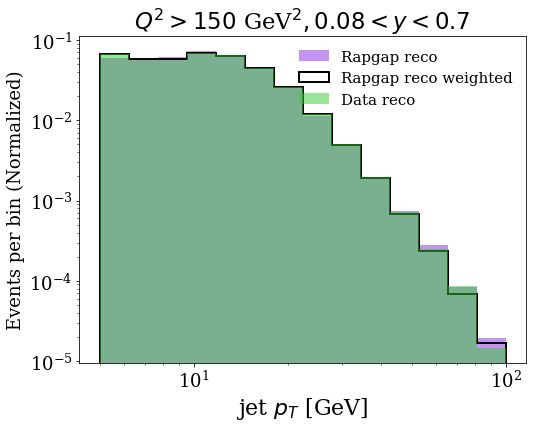

In [54]:
fig = plt.figure(figsize=(8,6))
query = 'pass_reco==1'
bins = np.logspace(np.log10(5),np.log10(100),15)
#bins = np.array([5,10,14,21,29,47,71,127])

#plt.set_xlabel(r'$ jet p_{T} $',fontsize=22)
#plt.set_ylabel('Events per bin (Normalized)')
plt.hist(mc_cut.query(query)['jet_pt'], weights = mc_cut.query(query)['wgt'],bins=bins, 
         label=mc_name+' reco', **plot_style_2,color=color1)
plt.hist(mc_cut.query(query)['jet_pt'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=mc_name +' reco weighted',
               **plot_style_1)

plt.hist(data_cut.query(query)['jet_pt'],
               bins=bins,
               label='Data reco',
               **plot_style_2,color=color2)
plt.legend()
plt.yscale('log')
plt.title(r'$Q^{2}>150$ GeV$^{2}, 0.08<y<0.7$')

plt.xlabel(r'jet $p_{T} $ [GeV]',fontsize=22)
plt.ylabel('Events per bin (Normalized)')
plt.xscale('log')
plt.legend(frameon=False,loc='best')
#fig.savefig('figures/jetpt_reco.png'%i)  


fig.savefig('figures/RealDataMC_jetpt_inclusivejet_%s_%s_%s_data_%s.png'%(mc_name,mc_tag,period,data_tag)) 


[0.         0.0063609  0.01407051 0.02341478 0.03474032 0.04846721
 0.06510462 0.08526965 0.10971029 0.13933307 0.17523676 0.21875313
 0.27149627 0.33542254 0.4129031  0.50681187 0.62063213 0.75858569
 0.92578957 1.12844568 1.37407099 1.67177624 2.03260396 2.469938
 3.        ]


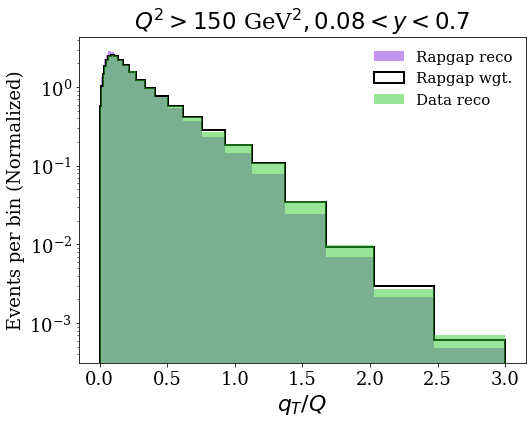

In [55]:
fig = plt.figure(figsize=(8,6))
query = 'pass_reco==1'
bins = np.logspace(np.log10(0.03),np.log10(3.03),25) - 0.03
bins[0] = 0.0
print (bins)
plt.hist(mc_cut.query(query)['jet_qtnorm'], weights = mc_cut.query(query)['wgt'], bins=bins, label=mc_name+' reco', **plot_style_2,color=color1)
plt.hist(mc_cut.query(query)['jet_qtnorm'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=mc_name +' wgt.',
               **plot_style_1)

plt.hist(data_cut.query(query)['jet_qtnorm'],
               bins=bins,
               label='Data reco',
               **plot_style_2,color=color2)
plt.legend()
plt.yscale('log')
plt.title(r'$Q^{2}>150$ GeV$^{2}, 0.08<y<0.7$')

plt.xlabel(r'$q_{T}/Q $ ',fontsize=22)
plt.ylabel('Events per bin (Normalized)')
#plt.xscale('log')
plt.legend(frameon=False,loc='best')


fig.savefig('figures/RealDataMC_jetqtnorm_inclusivejet_%s_%s_%s_data_%s.png'%(mc_name,mc_tag,period,data_tag)) 


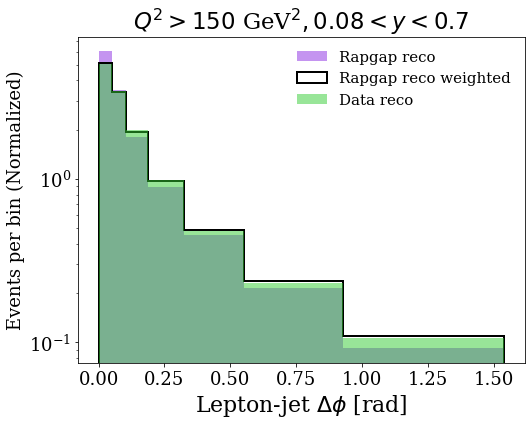

In [56]:
fig = plt.figure(figsize=(8,6))
query = 'pass_reco==1'
#bins = np.logspace(np.log10(5),np.log10(100),20)
#bins = np.array([5,10,14,21,29,47,71,127])
bins = np.logspace(np.log10(0.03),np.log10(np.pi/2.0),9) - 0.03
bins = bins[1:]
bins[0] = 0.0
#plt.set_xlabel(r'$ jet p_{T} $',fontsize=22)
#plt.set_ylabel('Events per bin (Normalized)')
plt.hist(mc_cut.query(query)['jet_dphi'], bins=bins,  weights = mc_cut.query(query)['wgt'], label=mc_name+' reco', **plot_style_2,color=color1)
plt.hist(mc_cut.query(query)['jet_dphi'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=mc_name +' reco weighted',
               **plot_style_1)

plt.hist(data_cut.query(query)['jet_dphi'],
               bins=bins,
               label='Data reco',
               **plot_style_2,color=color2)
plt.legend()
plt.yscale('log')
plt.title(r'$Q^{2}>150$ GeV$^{2}, 0.08<y<0.7$')

plt.xlabel(r'Lepton-jet $\Delta\phi$ [rad]',fontsize=22)
plt.ylabel('Events per bin (Normalized)')
#plt.xscale('log')
plt.legend(frameon=False,loc='best')
#fig.savefig('figures/jetpt_reco.png'%i)  


fig.savefig('figures/RealDataMC_dphi_inclusivejet_%s_%s_%s_data_%s.png'%(mc_name,mc_tag,period,data_tag)) 


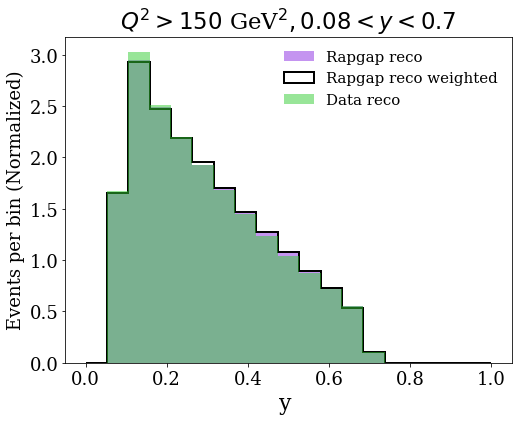

In [57]:
fig = plt.figure(figsize=(8,6))
query = 'pass_reco==1'
bins = np.linspace(0,1,20)

plt.hist(mc_cut.query(query)['y'], bins=bins, weights = mc_cut.query(query)['wgt'], label=mc_name+' reco', **plot_style_2,color=color1)
plt.hist(mc_cut.query(query)['y'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=mc_name +' reco weighted',
               **plot_style_1)

plt.hist(data_cut.query(query)['y'],
               bins=bins,
               label='Data reco',
               **plot_style_2,color=color2)
plt.legend()
#plt.yscale('log')
plt.title(r'$Q^{2}>150$ GeV$^{2}, 0.08<y<0.7$')

plt.xlabel(r'y ',fontsize=22)
plt.ylabel('Events per bin (Normalized)')
#plt.xscale('log')
plt.legend(frameon=False,loc='best')
#fig.savefig('figures/jetpt_reco.png'%i)  


fig.savefig('figures/DataMC_y_%s_%s_%s_data_%s.png'%(mc_name,mc_tag,period,data_tag)) 


In [58]:
print(len(mc_cut['y']))
print(len(mc_cut.query('pass_reco==1')['y']))

388026
301673


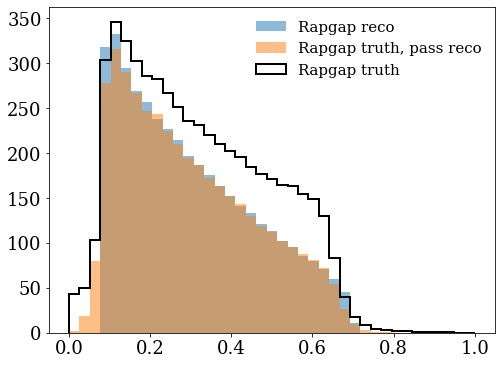

In [59]:
fig = plt.figure(figsize=(8,6))
bins = np.linspace(0,1,40)

plt.hist(mc_cut.query('pass_reco==1')['y'], weights = mc_cut.query('pass_reco==1')['wgt'],bins=bins, label=mc_name+' reco', **plot_style_2A)
plt.hist(mc_cut.query('pass_reco==1')['gen_y'],weights = mc_cut.query('pass_reco==1')['wgt'], bins=bins, label=mc_name+' truth, pass reco', **plot_style_2A)
plt.hist(mc_cut['gen_y'], bins=bins, weights = mc_cut['wgt'],label=mc_name+' truth', **plot_style_1A)


plt.legend()

In [60]:
mc.keys()

Index(['jet_pt', 'jet_phi', 'jet_eta', 'jet_dphi', 'jet_z', 'genjet_pt',
       'genjet_phi', 'genjet_eta', 'genjet_z', 'Q2', 'gen_Q2', 'y', 'gen_y',
       'e_px', 'e_py', 'e_pz', 'gene_px', 'gene_py', 'gene_pz', 'wgt',
       'vertex_z', 'ptmiss', 'ptratio_da', 'ptratio_ele', 'Empz', 'pth',
       'pass_reco', 'pass_truth', 'jet_px', 'jet_py', 'jet_pz', 'jet_qt',
       'jet_qtnorm', 'e_pt', 'e_phi', 'qt_px', 'qt_py', 'qt_phi', 'qt_dot_ept',
       'qt_dphi', 'qt_cos2phi', 'logQ2', 'Q', 'pthoverpte', 'gen_logQ2',
       'gen_Q', 'gene_pt', 'genjet_px', 'genjet_py', 'genjet_pz', 'genjet_qt',
       'genjet_qtnorm', 'gene_phi', 'genjet_dphi', 'genqt_px', 'genqt_py',
       'genqt_phi', 'genqt_dot_ept', 'genqt_dphi', 'genqt_cos2phi'],
      dtype='object')

## Data/MC agreement with differential 

Q>12.00 and Q<20.00 and pass_reco==1 and jet_pt>10
###########
Q>20.00 and Q<30.00 and pass_reco==1 and jet_pt>10
###########
Q>30.00 and Q<100.00 and pass_reco==1 and jet_pt>10
###########


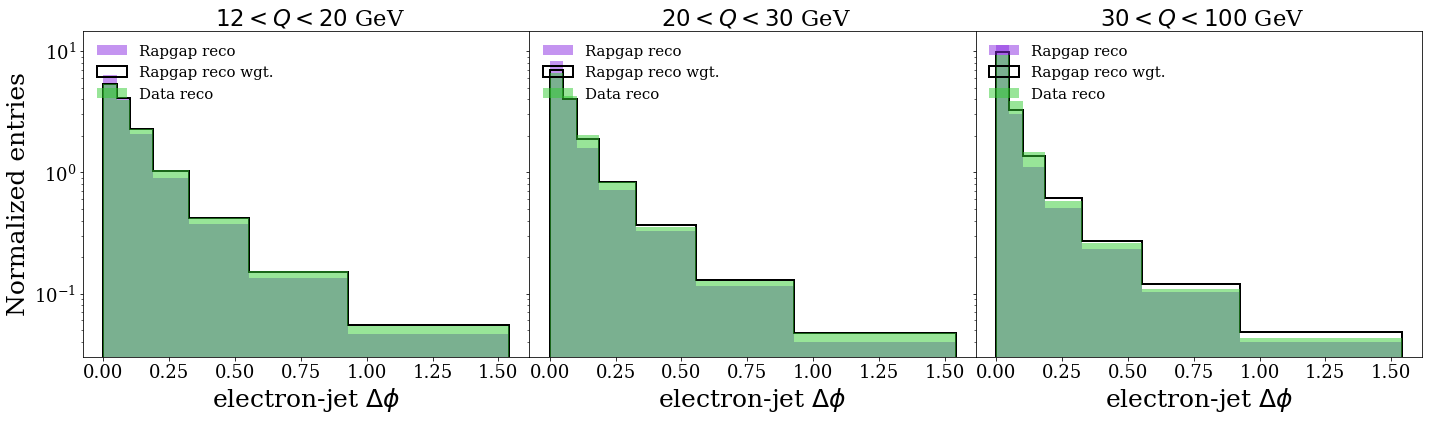

In [61]:
#bins = np.logspace(np.log10(0.01),np.log10(3),8)
bins = np.logspace(np.log10(0.03),np.log10(np.pi/2.0),9) - 0.03
bins = bins[1:]
bins[0] = 0.0

fig, axs = plt.subplots(1, 3,sharey=True, figsize=(24,6), gridspec_kw={'wspace':0, 'hspace':0})

for counter,edges in enumerate([(12,20), (20,30),(30,100)]):
    #cut = ' Q2 > %2.2f and Q2 <%2.2f and pass_reco==1'%(edges[0],edges[1])
    cut = 'Q>%2.2f and Q<%2.2f and pass_reco==1 and jet_pt>10'%(edges[0],edges[1])
    print (cut)
    print ('###########')

    axs[counter].xaxis.set_label_text(r'electron-jet $\Delta\phi$', fontsize=25)


    
    axs[counter].hist(mc_cut.query(cut)['jet_dphi'], weights=mc_cut.query(cut)['wgt'],bins=bins, label=mc_name+' reco', **plot_style_2,color=color1)
    axs[counter].hist(mc_cut.query(cut)['jet_dphi'],
               bins=bins,
               weights=mc_cut.query(cut)['weight_reco'],
               label=mc_name +' reco wgt.',
               **plot_style_1)
    axs[counter].hist(data_cut.query(cut)['jet_dphi'],
               bins=bins,
               label='Data reco',
               **plot_style_2,color=color2)    
    
    
    axs[counter].legend(prop={'size': 15}, frameon=False, loc='upper left')
    axs[counter].set_title(' $ %2.0f < Q < %2.0f$ GeV'%(edges[0],edges[1]))


    #axs[counter].text(1.5,2.9,  r'$\langle x \rangle = %2.2f, \langle Q^{2} \rangle = %2.0f \ \mathrm{GeV}^{2}$'%(data_cut.query(cut)['x'].mean(), data_cut.query(cut)['Q2'].mean()), fontsize=18)
    axs[counter].set_yscale('log')
    #axs[counter].set_xscale('log')

 
axs[0].yaxis.set_label_text('Normalized entries', fontsize=25)

fig.savefig('figures/RealDataMCcomparison_dphi_diff_%s_%s_%s_data_%s.png'%(mc_name,mc_tag,period,data_tag)) 


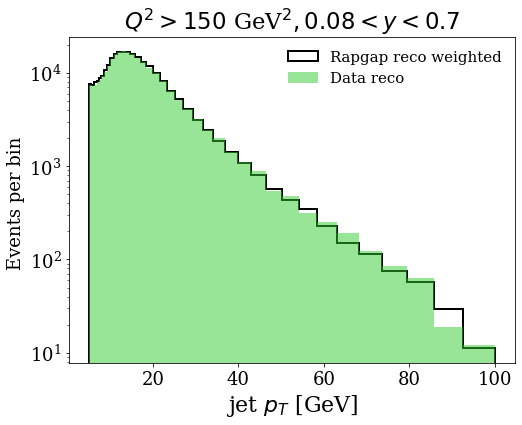

In [62]:
fig = plt.figure(figsize=(8,6))
query = 'pass_reco==1'
bins = np.logspace(np.log10(5),np.log10(100),40)

plt.hist(mc_cut.query(query)['jet_pt'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label='Rapgap reco weighted', color='black', histtype='step', lw=2
               )

plt.hist(data_cut.query(query)['jet_pt'],
               bins=bins,
               label='Data reco',
               color=color2, alpha=0.5)
plt.legend()
plt.yscale('log')
plt.title(r'$Q^{2}>150$ GeV$^{2}, 0.08<y<0.7$')

plt.xlabel(r'jet $p_{T} $ [GeV]',fontsize=22)
plt.ylabel('Events per bin ')
#plt.xscale('log')
plt.legend(frameon=False,loc='best')
#fig.savefig('figures/jetpt_reco.png'%i)  



In [63]:
altmc_cut = altmc

## Define fiducial region of the measurement

In [64]:
fiducialregion = 'gen_Q2>150 and gen_y>0.2 and gen_y<0.7 and genjet_pt>10 and genjet_eta<2.5 and genjet_eta>-1.0'


## Plot data, and unfolded results and MC truth

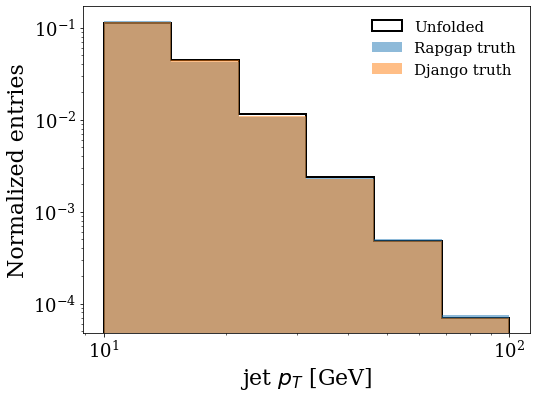

In [65]:
fig = plt.figure(figsize=(8,6))
cut = fiducialregion
bins = np.logspace(np.log10(10),np.log10(100),7)
plt.hist(mc_cut.query(cut)['genjet_pt'],bins=bins,weights=mc_cut.query(cut)['weight_truth'],label = 'Unfolded',**plot_style_1)

plt.hist(mc_cut.query(cut)['genjet_pt'],weights = mc_cut.query(cut)['wgt'], bins=bins,label = '%s truth'%(mc_name),**plot_style_2)
plt.hist(altmc_cut.query(cut)['genjet_pt'],weights = altmc_cut.query(cut)['wgt'],bins=bins,label = '%s truth'%(altmc_name),**plot_style_2)


plt.legend()
plt.ylabel('Normalized entries', fontsize=22)
plt.xlabel('jet $p_{T}$ [GeV]',fontsize=22)

plt.yscale('log')
plt.xscale('log')
fig.savefig('figures/Unfolded_jetpt_%s_%s_%s_data_%s.png'%(mc_name,mc_tag,period,data_tag)) 

plt.show()

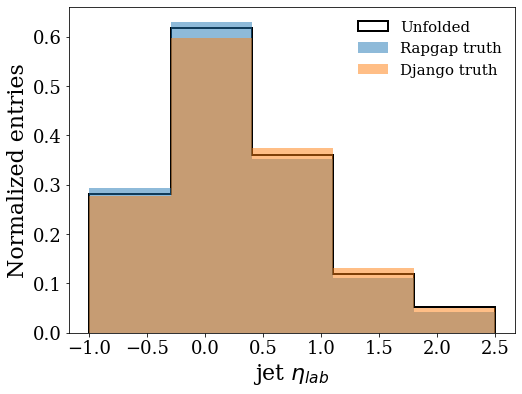

In [66]:
fig = plt.figure(figsize=(8,6))

cut = fiducialregion
bins = np.linspace(-1,2.5,6)
plt.hist(mc_cut.query(cut)['genjet_eta'],bins=bins,weights=mc_cut.query(cut)['weight_truth'],label = 'Unfolded',**plot_style_1)

plt.hist(mc_cut.query(cut)['genjet_eta'],bins=bins,weights = mc_cut.query(cut)['wgt'],label = '%s truth'%(mc_name),**plot_style_2)
plt.hist(altmc_cut.query(cut)['genjet_eta'],bins=bins,weights = altmc_cut.query(cut)['wgt'],label = '%s truth'%(altmc_name),**plot_style_2)



#plt.hist(altmc_cut.query(cut)['genjet_pt'],bins=bins,label = 'Rapgap truth',**plot_style_2)


plt.legend()
plt.ylabel('Normalized entries', fontsize=22)
plt.xlabel('jet $\eta_{lab}$ ',fontsize=22)


fig.savefig('figures/Unfolded_jeteta_%s_%s_%s_data_%s.png'%(mc_name,mc_tag,period,data_tag)) 

plt.show()

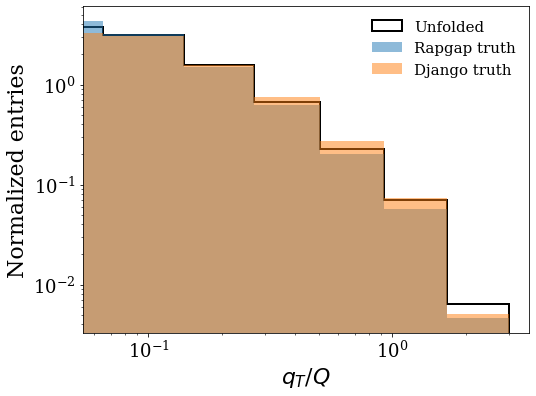

In [67]:
fig = plt.figure(figsize=(8,6))
cut = fiducialregion
bins = np.logspace(np.log10(0.03),np.log10(3.03),9) - 0.03
bins = bins[1:]
bins[0] = 0.0
plt.hist(mc_cut.query(cut)['genjet_qtnorm'],bins=bins,weights=mc_cut.query(cut)['weight_truth'],label = 'Unfolded',**plot_style_1)

plt.hist(mc_cut.query(cut)['genjet_qtnorm'],bins=bins,weights = mc_cut.query(cut)['wgt'],label = '%s truth'%(mc_name),**plot_style_2)
plt.hist(altmc_cut.query(cut)['genjet_qtnorm'],bins=bins,weights = altmc_cut.query(cut)['wgt'],label = '%s truth'%(altmc_name),**plot_style_2)


plt.legend()
plt.ylabel('Normalized entries', fontsize=22)
plt.xlabel('$q_{T}$/$Q$ ',fontsize=22)

plt.yscale('log')
plt.xscale('log')
fig.savefig('figures/Unfolded_jetqt_%s_%s_%s_data_%s.png'%(mc_name,mc_tag,period,data_tag)) 

plt.show()

In [68]:
bins = np.geomspace(np.pi,2*np.pi,10) - np.pi
bins[0] = 0
print(bins)

[0.         0.25151509 0.52316641 0.81656606 1.13345521 1.47571443
 1.84537483 2.24463014 2.67584973 3.14159265]


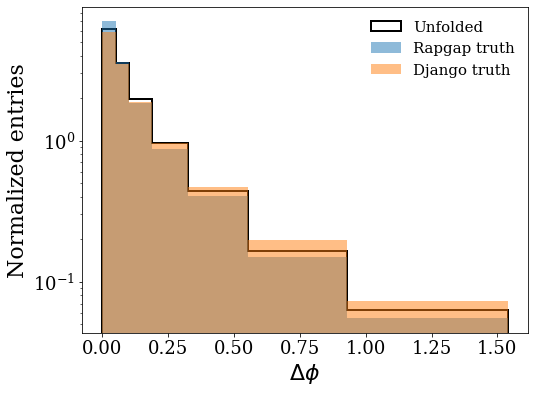

In [69]:
fig = plt.figure(figsize=(8,6))
cut = fiducialregion
bins = np.logspace(np.log10(0.03),np.log10(np.pi/2.0),9) - 0.03
bins = bins[1:]
bins[0] = 0.0

plt.hist(mc_cut.query(cut)['genjet_dphi'],bins=bins,weights=mc_cut.query(cut)['weight_truth'],label = 'Unfolded',**plot_style_1)

plt.hist(mc_cut.query(cut)['genjet_dphi'],bins=bins,weights = mc_cut.query(cut)['wgt'],label = '%s truth'%(mc_name),**plot_style_2)

plt.hist(altmc_cut.query(cut)['genjet_dphi'],bins=bins,weights = altmc_cut.query(cut)['wgt'],label = '%s truth'%(altmc_name),**plot_style_2)

plt.legend()
plt.ylabel('Normalized entries', fontsize=22)
plt.xlabel('$\Delta\phi$ ',fontsize=22)

plt.yscale('log')
#plt.xscale('log')
fig.savefig('figures/Unfolded_jetdphi_%s_%s_%s_data_%s.png'%(mc_name,mc_tag,period,data_tag)) 

plt.show()

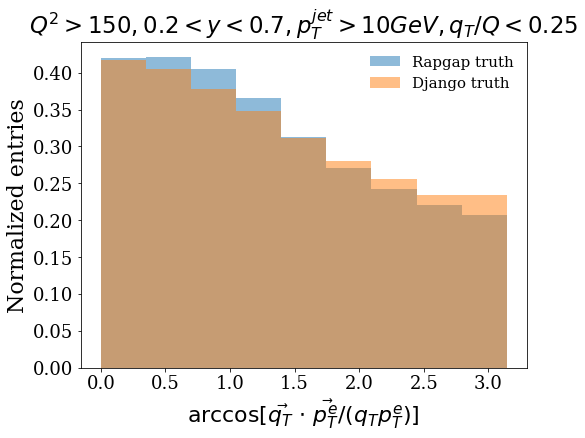

In [70]:
fig = plt.figure(figsize=(8,6))
cut = fiducialregion + 'and genjet_qtnorm<0.25'
bins = np.linspace(0,np.pi,10) 

#plt.hist(mc_cut.query(cut)['genqt_dphi'],bins=bins,weights=mc_cut.query(cut)['weight_truth'],label = 'Data Unfolded',**plot_style_1)

plt.hist(mc_cut.query(cut)['genqt_dphi'],bins=bins,weights = mc_cut.query(cut)['wgt'],label = '%s truth'%(mc_name),**plot_style_2)

plt.hist(altmc_cut.query(cut)['genqt_dphi'],bins=bins,weights = altmc_cut.query(cut)['wgt'],label = '%s truth'%(altmc_name),**plot_style_2)

plt.legend()
plt.ylabel('Normalized entries', fontsize=22)
plt.xlabel(r'$\arccos[\vec{q_{T}}$ $\cdot$ $\vec{p_{T}^{e}}/(q_{T}p_{T}^{e})]$ ',fontsize=22)
plt.title(r'$Q^{2}>150, 0.2<y<0.7, p_{T}^{jet}>10 GeV, q_{T}/Q<0.25$')
#plt.yscale('log')
#plt.xscale('log')
fig.savefig('figures/Unfolded_jetdphi_%s_%s_%s_data_%s.png'%(mc_name,mc_tag,period,data_tag)) 


[ 8.98735251e+03  3.35996417e-01 -3.10755788e-02]
The average cosx is :  0.16799820825377976


Text(0.5, 1.0, '$Q^{2}>150, 0.2<y<0.7, p_{T}^{jet}>10 GeV, q_{T}/Q<0.25$')

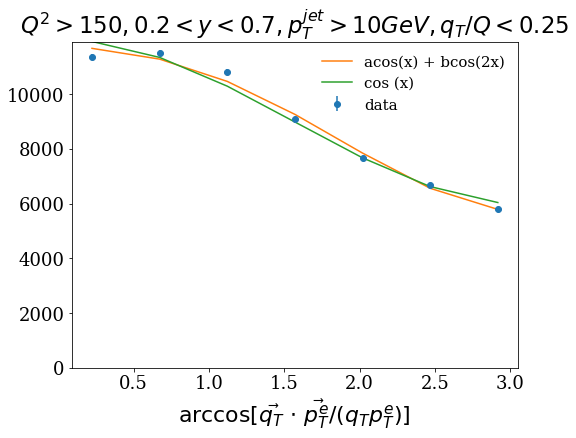

In [96]:
from scipy.optimize import curve_fit
def f (xx,a0,b1,b2):
    return a0*(1+b1*np.cos(xx)+b2*np.cos(2*xx))


def fit(x,y,dy):
    def f (xx,a0,b1,b2):
        return a0*(1+b1*np.cos(xx)+b2*np.cos(2*xx))
    p,cov = curve_fit(f, x, y,sigma=dy)
    return p,cov

fig = plt.figure(figsize=(8,6))
cut = fiducialregion + 'and genjet_qtnorm<0.2'
bins = np.linspace(0,np.pi,8) 

y,x = np.histogram(mc_cut.query(cut)['genqt_dphi'],bins=bins,weights=mc_cut.query(cut)['weight_truth'])
x = (x[1:]+x[:-1])/2

plt.errorbar(x,y,yerr=np.sqrt(y),fmt='o',label='data')
plt.ylim(bottom=0)
p, cov = fit(x,y,np.sqrt(y))
print(p)
plt.plot(x, f(x,p[0],p[1],p[2]) , label='acos(x) + bcos(2x)')
plt.plot(x, f(x,p[0],p[1],0),label='cos (x)')
plt.xlabel(r'$\arccos[\vec{q_{T}}$ $\cdot$ $\vec{p_{T}^{e}}/(q_{T}p_{T}^{e})]$ ',fontsize=22)
plt.legend()
print('The average cosx is : ', p[1]/2.0)
plt.title(r'$Q^{2}>150, 0.2<y<0.7, p_{T}^{jet}>10 GeV, q_{T}/Q<0.25$')


## Final Cross section measurements. Save them in pickle files

In [72]:
label_DISselection_truth = r'$Q^{2}>150$ GeV$^{2}, 0.2<y<0.7$'

In [73]:
lumi = 139 #pb-1. This is for the 0607 dataset

## Calculate total jet cross-section


In [74]:
fiducialregion = 'gen_Q2>150 and gen_y>0.2 and gen_y<0.7 and genjet_pt>10 and genjet_eta<2.5 and genjet_eta>-1.0'
bins = np.logspace(np.log10(10),np.log10(100),7)
y,x = np.histogram(mc_cut.query(fiducialregion)['genjet_pt'],bins=bins,weights=mc_cut.query(fiducialregion)['weight_truth'])
total = np.sum(y)/lumi
print('Total cross-section is: %f' %total)

Total cross-section is: 762.629578


[1.13316828e-01 4.45243691e-02 1.15030478e-02 2.40369035e-03
 4.81886464e-04 6.99872280e-05]
[12.33899634 18.11116979 26.58356175 39.01933247 57.27254762 84.06460345]


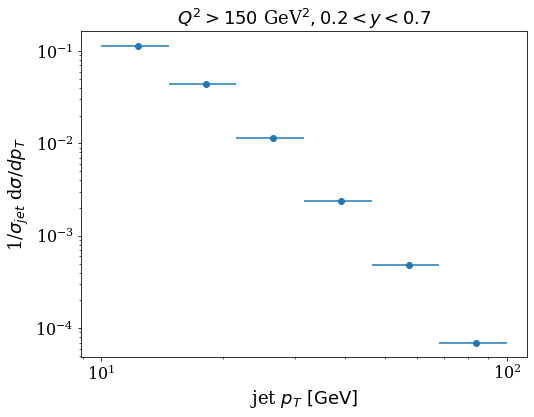

In [75]:

fig = plt.figure(figsize=(8,6))
bins = np.logspace(np.log10(10),np.log10(100),7)

y,x = np.histogram(mc_cut.query(fiducialregion)['genjet_pt'],bins=bins,weights=mc_cut.query(fiducialregion)['weight_truth'])
xerr = (x[1:] - x[:-1])/2.0
x = (x[1:]+x[:-1])/2
y = y/lumi
y = y/total
y = y/(xerr*2.0)

with open('outputfiles/CrossSection_jetpt_%s_%s_%s_data_%s.npy'%(mc_name,mc_tag,period,data_tag) , 'wb') as f:
    np.save(f, y)
    np.save(f, x)
    np.save(f, xerr)



    
    
print(y)
print(x)
plt.errorbar(x,y, xerr=xerr, fmt='o',ls='none',label='data unfold')






plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.xlabel(r'jet $p_{T}$ $[\mathrm{GeV}]$',fontsize=18)
plt.ylabel(r'1/$\sigma_{jet}$ d$\sigma/dp_{T}$ ',fontsize=18)

plt.yscale('log')
plt.xscale('log')

plt.title(label_DISselection_truth, fontsize=18)

fig.savefig('figures/CrossSection_jetpt_%s.png'%(mc_name)) 




[0.28054586 0.61773947 0.35920346 0.11934574 0.05189705]
[-0.65  0.05  0.75  1.45  2.15]


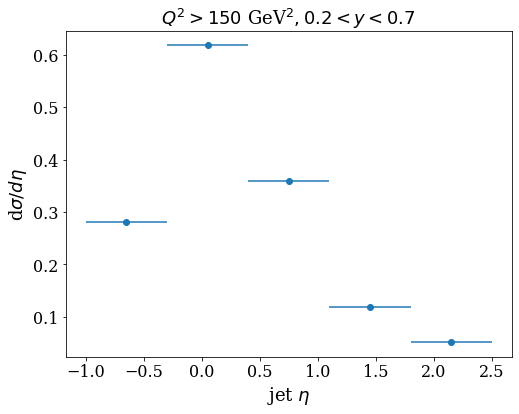

In [76]:
fig = plt.figure(figsize=(8,6))
bins = np.linspace(-1,2.5,6)

y,x = np.histogram(mc_cut.query(fiducialregion)['genjet_eta'],bins=bins,weights=mc_cut.query(fiducialregion)['weight_truth'])
xerr = (x[1:] - x[:-1])/2.0
x = (x[1:]+x[:-1])/2
y = y/lumi
y = y/total
y = y/(xerr*2.0)

print(y)
print(x)
plt.errorbar(x,y, xerr=xerr, fmt='o',ls='none',label='data unfold')
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.xlabel(r'jet $\eta$',fontsize=18)
plt.ylabel(r'd$\sigma/d\eta$ ',fontsize=18)
#plt.yscale('log')
#plt.xscale('log')

plt.title(label_DISselection_truth, fontsize=18)

fig.savefig('figures/CrossSection_jeteta_%s.png'%(mc_name)) 

with open('outputfiles/CrossSection_jeteta_%s_%s_%s_data_%s.npy'%(mc_name,mc_tag,period,data_tag) , 'wb') as f:
    np.save(f, y)
    np.save(f, x)
    np.save(f, xerr)


In [77]:
x =  np.logspace(np.log10(0.03),np.log10(3),9) -0.03
print(x)

[-3.46944695e-18  2.33483823e-02  6.48683298e-02  1.38702398e-01
  2.70000000e-01  5.03483823e-01  9.18683298e-01  1.65702398e+00
  2.97000000e+00]


[3.74136939 3.13447784 1.57965575 0.6731262  0.22868876 0.07000363
 0.00634213]
[0.03255231 0.10221884 0.20541467 0.38915407 0.71630072 1.2987829
 2.33588812]


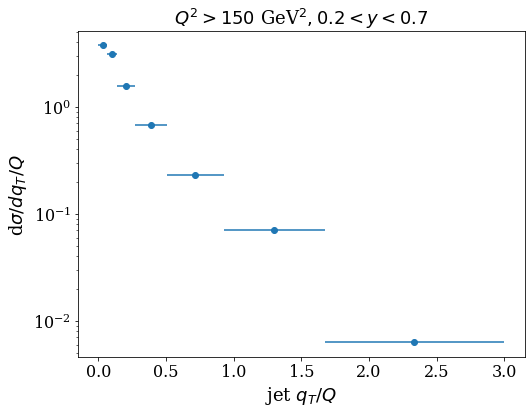

In [78]:
fig = plt.figure(figsize=(8,6))
bins = np.logspace(np.log10(0.03),np.log10(3.03),9) - 0.03
bins = bins[1:]
bins[0] = 0.0
y,x = np.histogram(mc_cut.query(fiducialregion)['genjet_qtnorm'],bins=bins,weights=mc_cut.query(fiducialregion)['weight_truth'])
xerr = (x[1:] - x[:-1])/2.0
x = (x[1:]+x[:-1])/2
y = y/lumi
y = y/total
y = y/(xerr*2.0)

print(y)
print(x)

plt.errorbar(x,y, xerr=xerr,fmt='o',ls='none',label='data unfold')
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.xlabel(r'jet $q_{T}/Q$ ',fontsize=18)
plt.ylabel(r'd$\sigma/dq_{T}/Q $ ',fontsize=18)
plt.yscale('log')
plt.title(label_DISselection_truth, fontsize=18)
#plt.xscale('log')
fig.savefig('figures/CrossSection_jetqt_%s.png'%(mc_name)) 

with open('outputfiles/CrossSection_qt_%s_%s_%s_data_%s.npy'%(mc_name,mc_tag,period,data_tag) , 'wb') as f:
    np.save(f, y)
    np.save(f, x)
    np.save(f, xerr)

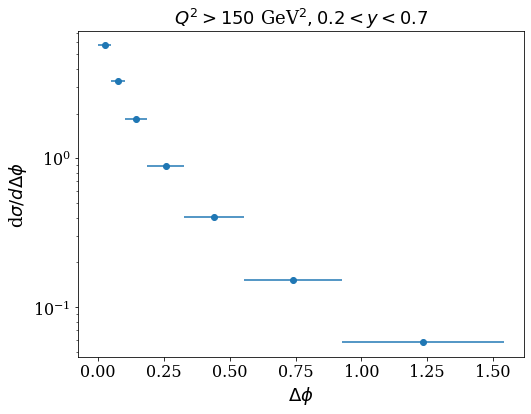

In [79]:
fig = plt.figure(figsize=(8,6))

bins = np.logspace(np.log10(0.03),np.log10(np.pi/2.0),9) - 0.03
bins = bins[1:]
bins[0] = 0.0

y,x = np.histogram(mc_cut.query(fiducialregion)['genjet_dphi'],bins=bins,weights=mc_cut.query(fiducialregion)['weight_truth'])
xerr = (x[1:] - x[:-1])/2.0
x = (x[1:]+x[:-1])/2
y = y/lumi
y = y/total
y = y/(xerr*2.0)

plt.errorbar(x,y, xerr=xerr,fmt='o',ls='none',label='data unfold')
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.xlabel(r'$\Delta\phi$ ',fontsize=18)
plt.ylabel(r'd$\sigma/d\Delta\phi  $ ',fontsize=18)
plt.yscale('log')
plt.title(label_DISselection_truth, fontsize=18)
fig.savefig('figures/CrossSection_jetdphi_%s.png'%(mc_name)) 

with open('outputfiles/CrossSection_dphi_%s_%s_%s_data_%s.npy'%(mc_name,mc_tag,period,data_tag) , 'wb') as f:
    np.save(f, y)
    np.save(f, x)
    np.save(f, xerr)
#plt.xscale('log')

In [80]:
print('%s_%s_%s_data_%s.npy'%(mc_name,mc_tag,period,data_tag))

Rapgap_nominal_ep0607_data_nominal.npy


# FIN

## Checking stability of the result vs number of iterations

In [81]:
bins = np.logspace(np.log10(10),np.log10(100),7)


y,x = np.histogram(mc_cut.query(fiducialregion)['genjet_pt'],bins=bins,weights=mc_cut.query(fiducialregion)['weight_truth'])
total = np.sum(y)/lumi
print('Total cross-section is: %2.12f' %total)


y,x = np.histogram(mc_cut.query(fiducialregion)['genjet_pt'],bins=bins,weights=mc_cut.query(fiducialregion)['weight_truth_next'])
total_next = np.sum(y)/lumi
print('Total cross-section is: %2.12f' %total_next)

y,x = np.histogram(mc_cut.query(fiducialregion)['genjet_pt'],bins=bins,weights=mc_cut.query(fiducialregion)['weight_truth_previous'])
total_previous = np.sum(y)/lumi
print('Total cross-section is: %2.12f' %total_previous)

Total cross-section is: 762.629578464537
Total cross-section is: 713.159975017789
Total cross-section is: 729.965899729900


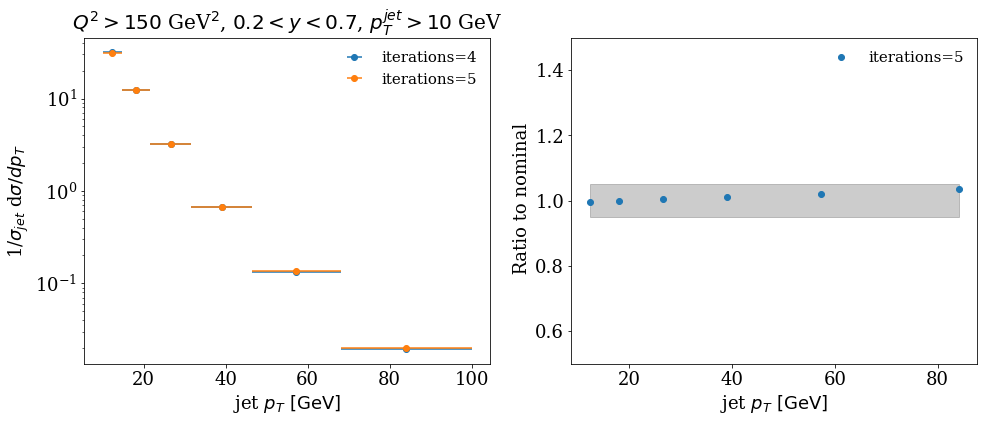

In [82]:
fig,ax = plt.subplots(1,2,figsize=(16, 6))
bins = np.logspace(np.log10(10),np.log10(100),7)


cut = fiducialregion

ynom, x  = np.histogram(mc_cut.query(cut)['genjet_pt'],bins=bins,weights=mc_cut.query(cut)['weight_truth'])
ynext, x = np.histogram(mc_cut.query(cut)['genjet_pt'],bins=bins,weights=mc_cut.query(cut)['weight_truth_next'])
ydo, x   = np.histogram(mc_cut.query(cut)['genjet_pt'],bins=bins,weights=mc_cut.query(cut)['weight_truth_previous'])
xerr = (x[1:] - x[:-1])/2.0
ynom = ynom/total
ynext = ynext/total_next
ydo   = ydo/total_previous
ynom = ynom/xerr
ynext = ynext/xerr
ydo  = ydo/xerr
x = (x[1:]+x[:-1])/2
ax[0].errorbar(x,ynom,xerr=xerr,fmt='o',label='iterations=%i'%(iterations-1))
ax[0].errorbar(x,ynext,xerr=xerr,fmt='o',label='iterations=%i'%(iterations))
#ax[0].errorbar(x,ydo,xerr=xerr,fmt='o',label='iterations=%i'%(iterations-2))
ax[0].legend()
ax[0].set_yscale('log')


ratio = np.true_divide(ynext,ynom)
ax[1].plot(x,ratio,'o',label='iterations=%i'%(iterations))
#ratio = np.true_divide(ydo,ynom)
#ax[1].plot(x,ratio,'o',label='iterations=%i'%(iterations-2))


ax[1].legend()


ax[1].fill_between(x, 0.95,1.05,alpha=0.2,color='black')
ax[1].set_ylim([0.5,1.5])
ax[0].set_title('$Q^{2}>150$ GeV$^{2}$, $0.2<y<0.7$, $p_{T}^{jet}>10$ GeV',fontsize=20)

ax[0].set_ylabel(r'1/$\sigma_{jet}$ d$\sigma/dp_{T}$ ',fontsize=18)
ax[1].set_ylabel(' Ratio to nominal')
ax[1].set_xlabel(r'jet $p_{T}$ $[\mathrm{GeV}]$',fontsize=18)
ax[0].set_xlabel(r'jet $p_{T}$ $[\mathrm{GeV}]$',fontsize=18)

#ax[0].set_ylim(bottom=1)
fig.savefig('figures/Iterations_jetpt_%s_%s_%s_data_%s.png'%(mc_name,mc_tag,period,data_tag)) 

plt.show()

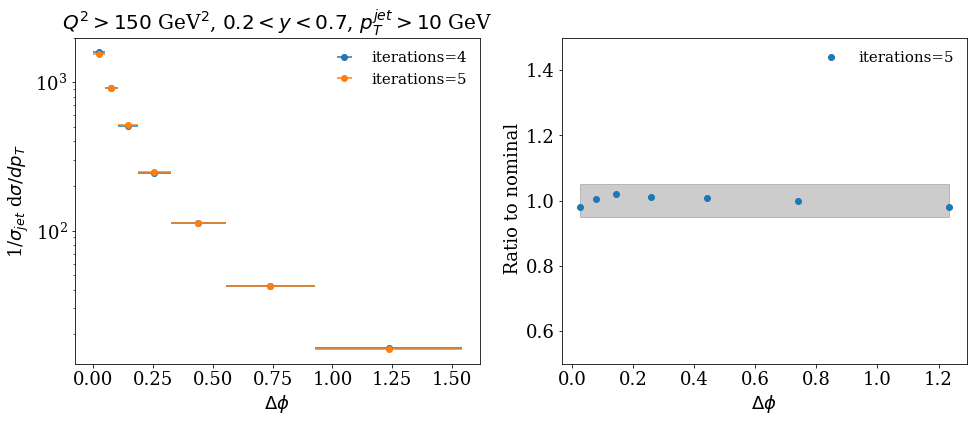

In [83]:
fig,ax = plt.subplots(1,2,figsize=(16, 6))
bins = np.logspace(np.log10(0.03),np.log10(np.pi/2.0),9) - 0.03
bins = bins[1:]
bins[0] = 0.0
cut = fiducialregion

ynom, x  = np.histogram(mc_cut.query(cut)['genjet_dphi'],bins=bins,weights=mc_cut.query(cut)['weight_truth'])
ynext, x = np.histogram(mc_cut.query(cut)['genjet_dphi'],bins=bins,weights=mc_cut.query(cut)['weight_truth_next'])
ydo, x   = np.histogram(mc_cut.query(cut)['genjet_dphi'],bins=bins,weights=mc_cut.query(cut)['weight_truth_previous'])
xerr = (x[1:] - x[:-1])/2.0
ynom = ynom/total
ynext = ynext/total_next
ydo   = ydo/total_previous
ynom = ynom/xerr
ynext = ynext/xerr
ydo  = ydo/xerr
x = (x[1:]+x[:-1])/2
ax[0].errorbar(x,ynom,xerr=xerr,fmt='o',label='iterations=%i'%(iterations-1))
ax[0].errorbar(x,ynext,xerr=xerr,fmt='o',label='iterations=%i'%(iterations))
#ax[0].errorbar(x,ydo,xerr=xerr,fmt='o',label='iterations=%i'%(iterations-2))
ax[0].legend()
ax[0].set_yscale('log')


ratio = np.true_divide(ynext,ynom)
ax[1].plot(x,ratio,'o',label='iterations=%i'%(iterations))
#ratio = np.true_divide(ydo,ynom)
#ax[1].plot(x,ratio,'o',label='iterations=%i'%(iterations-2))


ax[1].legend()


ax[1].fill_between(x, 0.95,1.05,alpha=0.2,color='black')
ax[1].set_ylim([0.5,1.5])
ax[0].set_title('$Q^{2}>150$ GeV$^{2}$, $0.2<y<0.7$, $p_{T}^{jet}>10$ GeV',fontsize=20)

ax[0].set_ylabel(r'1/$\sigma_{jet}$ d$\sigma/dp_{T}$ ',fontsize=18)
ax[1].set_ylabel(' Ratio to nominal')



ax[1].set_xlabel(r'$\Delta\phi$ ',fontsize=18)
ax[0].set_xlabel(r'$\Delta\phi$ ',fontsize=18)

fig.savefig('figures/Iterations_jetdphi_%s_%s_%s_data_%s.png'%(mc_name,mc_tag,period,data_tag)) 

plt.show()

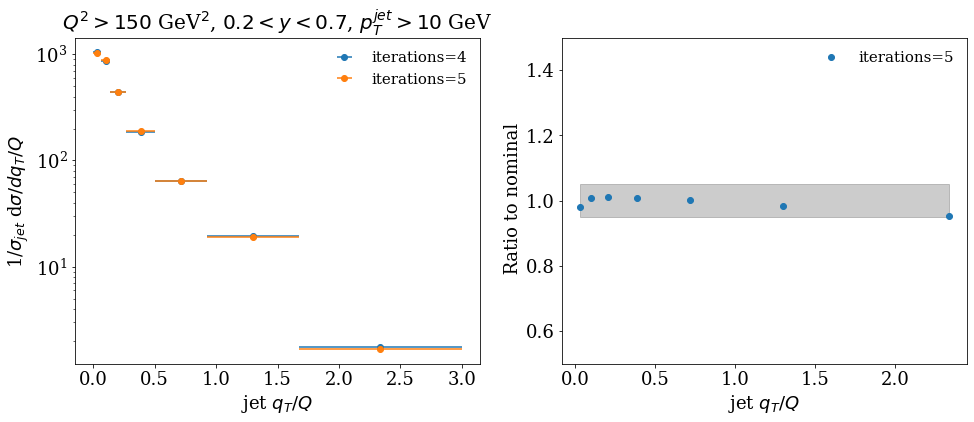

In [84]:
fig,ax = plt.subplots(1,2,figsize=(16, 6))
bins = np.logspace(np.log10(0.03),np.log10(3.03),9) - 0.03
bins = bins[1:]
bins[0] = 0.0
cut = fiducialregion

ynom, x  = np.histogram(mc_cut.query(cut)['genjet_qtnorm'],bins=bins,weights=mc_cut.query(cut)['weight_truth'])
ynext, x = np.histogram(mc_cut.query(cut)['genjet_qtnorm'],bins=bins,weights=mc_cut.query(cut)['weight_truth_next'])
ydo, x   = np.histogram(mc_cut.query(cut)['genjet_qtnorm'],bins=bins,weights=mc_cut.query(cut)['weight_truth_previous'])
xerr = (x[1:] - x[:-1])/2.0
ynom = ynom/total
ynext = ynext/total_next
ydo   = ydo/total_previous
ynom = ynom/xerr
ynext = ynext/xerr
ydo  = ydo/xerr
x = (x[1:]+x[:-1])/2
ax[0].errorbar(x,ynom,xerr=xerr,fmt='o',label='iterations=%i'%(iterations-1))
ax[0].errorbar(x,ynext,xerr=xerr,fmt='o',label='iterations=%i'%(iterations))
#ax[0].errorbar(x,ydo,xerr=xerr,fmt='o',label='iterations=%i'%(iterations-2))
ax[0].legend()
ax[0].set_yscale('log')


ratio = np.true_divide(ynext,ynom)
ax[1].plot(x,ratio,'o',label='iterations=%i'%(iterations))
#ratio = np.true_divide(ydo,ynom)
#ax[1].plot(x,ratio,'o',label='iterations=%i'%(iterations-2))


ax[1].legend()


ax[1].fill_between(x, 0.95,1.05,alpha=0.2,color='black')
ax[1].set_ylim([0.5,1.5])
ax[0].set_title('$Q^{2}>150$ GeV$^{2}$, $0.2<y<0.7$, $p_{T}^{jet}>10$ GeV',fontsize=20)

ax[0].set_ylabel(r'1/$\sigma_{jet}$ d$\sigma/dq_{T}/Q$ ',fontsize=18)

ax[1].set_ylabel(' Ratio to nominal')
ax[0].set_xlabel(r'jet $q_{T}/Q$ ',fontsize=18)
ax[1].set_xlabel(r'jet $q_{T}/Q$ ',fontsize=18)

ax[0].legend()
#ax[0].set_xscale('log')
#ax[1].set_xscale('log')

fig.savefig('figures/Iterations_jetqt_%s_%s_%s_data_%s.png'%(mc_name,mc_tag,period,data_tag)) 

plt.show()

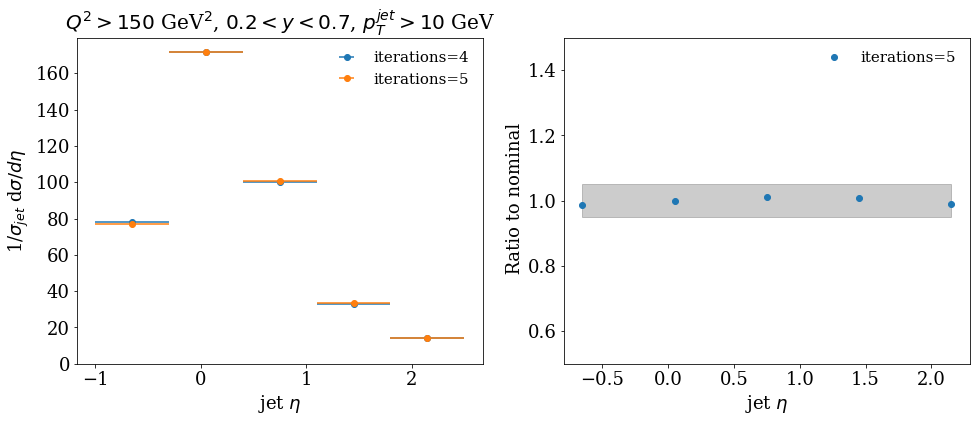

In [85]:
fig,ax = plt.subplots(1,2,figsize=(16, 6))
bins = np.linspace(-1,2.5,6)
cut = fiducialregion

ynom, x  = np.histogram(mc_cut.query(cut)['genjet_eta'],bins=bins,weights=mc_cut.query(cut)['weight_truth'])
ynext, x = np.histogram(mc_cut.query(cut)['genjet_eta'],bins=bins,weights=mc_cut.query(cut)['weight_truth_next'])
ydo, x   = np.histogram(mc_cut.query(cut)['genjet_eta'],bins=bins,weights=mc_cut.query(cut)['weight_truth_previous'])
xerr = (x[1:] - x[:-1])/2.0
ynom = ynom/total
ynext = ynext/total_next
ydo   = ydo/total_previous
ynom = ynom/xerr
ynext = ynext/xerr
ydo  = ydo/xerr
x = (x[1:]+x[:-1])/2
ax[0].errorbar(x,ynom,xerr=xerr,fmt='o',label='iterations=%i'%(iterations-1))
ax[0].errorbar(x,ynext,xerr=xerr,fmt='o',label='iterations=%i'%(iterations))
#ax[0].errorbar(x,ydo,xerr=xerr,fmt='o',label='iterations=%i'%(iterations-2))
ax[0].legend()
#ax[0].set_yscale('log')


ratio = np.true_divide(ynext,ynom)
ax[1].plot(x,ratio,'o',label='iterations=%i'%(iterations))
#ratio = np.true_divide(ydo,ynom)
#ax[1].plot(x,ratio,'o',label='iterations=%i'%(iterations-2))


ax[1].legend()


ax[1].fill_between(x, 0.95,1.05,alpha=0.2,color='black')
ax[1].set_ylim([0.5,1.5])
ax[0].set_title('$Q^{2}>150$ GeV$^{2}$, $0.2<y<0.7$, $p_{T}^{jet}>10$ GeV',fontsize=20)

ax[0].set_ylabel(r'1/$\sigma_{jet}$ d$\sigma/d\eta$ ',fontsize=18)

ax[1].set_ylabel(' Ratio to nominal')

ax[1].set_xlabel(r'jet $\eta$',fontsize=18)
ax[0].set_xlabel(r'jet $\eta$',fontsize=18)
ax[0].set_ylim(bottom=0.0)

fig.savefig('figures/Iterations_jeteta_%s_%s_%s_data_%s.png'%(mc_name,mc_tag,period,data_tag)) 

plt.show()

In [86]:
bins = np.logspace(np.log10(10),np.log10(100),7)


y,x = np.histogram(mc_cut.query(fiducialregion)['genjet_pt'],bins=bins,weights=mc_cut.query(fiducialregion)['wgt'])
total_mc = np.sum(y)
print('Total cross-section is: %2.12f' %total)

Total cross-section is: 762.629578464537


[1.17819799e-01 4.27682237e-02 1.06752177e-02 2.32519189e-03
 4.98419818e-04 7.43466143e-05]
[12.33899634 18.11116979 26.58356175 39.01933247 57.27254762 84.06460345]


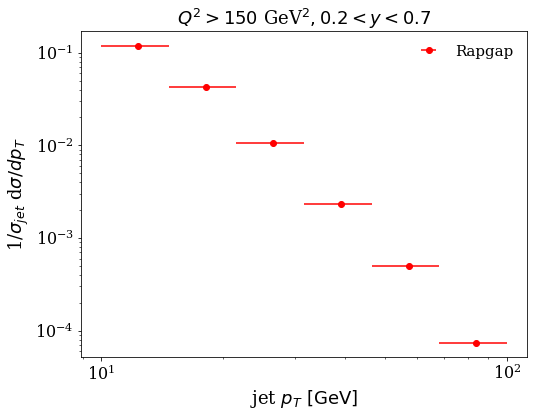

In [87]:
fig = plt.figure(figsize=(8,6))
bins = np.logspace(np.log10(10),np.log10(100),7)

y,x = np.histogram(mc_cut.query(fiducialregion)['genjet_pt'],
                   bins=bins,weights=mc_cut.query(fiducialregion)['wgt'])
xerr = (x[1:] - x[:-1])/2.0
x = (x[1:]+x[:-1])/2
y = y/total_mc
y = y/(xerr*2.0)

with open('outputfiles/MCCrossSection_jetpt_%s_%s_%s_data_%s.npy'%(mc_name,mc_tag,period,data_tag) , 'wb') as f:
    np.save(f, y)
    np.save(f, x)
    np.save(f, xerr)

print(y)
print(x)
plt.errorbar(x,y, xerr=xerr, fmt='o',ls='none',label=mc_name,color='red')
plt.legend()
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.xlabel(r'jet $p_{T}$ $[\mathrm{GeV}]$',fontsize=18)
plt.ylabel(r'1/$\sigma_{jet}$ d$\sigma/dp_{T}$ ',fontsize=18)

plt.yscale('log')
plt.xscale('log')

plt.title(label_DISselection_truth, fontsize=18)

fig.savefig('figures/MCCrossSection_jetpt_%s.png'%(mc_name)) 



[0.29238724 0.62933734 0.35288249 0.11153353 0.04268211]
[-0.65  0.05  0.75  1.45  2.15]


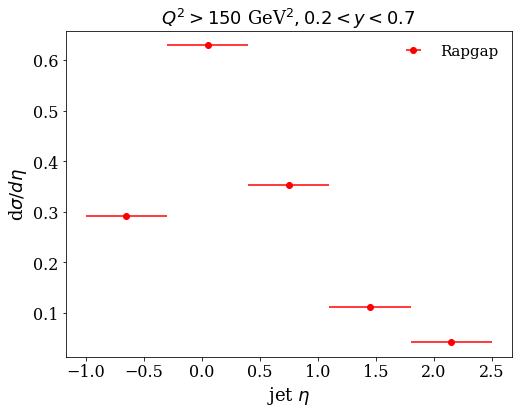

In [88]:
fig = plt.figure(figsize=(8,6))
bins = np.linspace(-1,2.5,6)

y,x = np.histogram(mc_cut.query(fiducialregion)['genjet_eta'],bins=bins,weights=mc_cut.query(fiducialregion)['wgt'])
xerr = (x[1:] - x[:-1])/2.0
x = (x[1:]+x[:-1])/2
y = y/total_mc
y = y/(xerr*2.0)

print(y)
print(x)
plt.errorbar(x,y, xerr=xerr, fmt='o',ls='none',label=mc_name,color='red')
plt.legend()
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.xlabel(r'jet $\eta$',fontsize=18)
plt.ylabel(r'd$\sigma/d\eta$ ',fontsize=18)
#plt.yscale('log')
#plt.xscale('log')

plt.title(label_DISselection_truth, fontsize=18)

fig.savefig('figures/MCCrossSection_jeteta_%s.png'%(mc_name)) 

with open('outputfiles/MCCrossSection_jeteta_%s_%s_%s_data_%s.npy'%(mc_name,mc_tag,period,data_tag) , 'wb') as f:
    np.save(f, y)
    np.save(f, x)
    np.save(f, xerr)

[4.2897868  3.22421996 1.50514947 0.63129728 0.20377733 0.05677345
 0.00465452]
[0.03255231 0.10221884 0.20541467 0.38915407 0.71630072 1.2987829
 2.33588812]


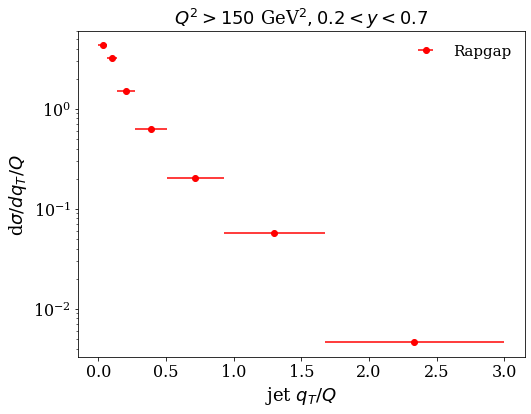

In [89]:
fig = plt.figure(figsize=(8,6))
bins = np.logspace(np.log10(0.03),np.log10(3.03),9) - 0.03
bins = bins[1:]
bins[0] = 0.0
y,x = np.histogram(mc_cut.query(fiducialregion)['genjet_qtnorm'],bins=bins,weights=mc_cut.query(fiducialregion)['wgt'])
xerr = (x[1:] - x[:-1])/2.0
x = (x[1:]+x[:-1])/2
y = y/total_mc
y = y/(xerr*2.0)

print(y)
print(x)

plt.errorbar(x,y, xerr=xerr,fmt='o',ls='none',label=mc_name,color='red')
plt.legend()
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.xlabel(r'jet $q_{T}/Q$ ',fontsize=18)
plt.ylabel(r'd$\sigma/dq_{T}/Q $ ',fontsize=18)
plt.yscale('log')
plt.title(label_DISselection_truth, fontsize=18)
#plt.xscale('log')
fig.savefig('figures/MCCrossSection_jetqt_%s.png'%(mc_name)) 

with open('outputfiles/MCCrossSection_qt_%s_%s_%s_data_%s.npy'%(mc_name,mc_tag,period,data_tag) , 'wb') as f:
    np.save(f, y)
    np.save(f, x)
    np.save(f, xerr)

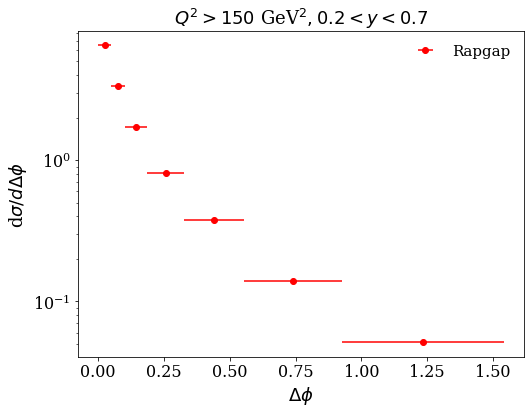

In [90]:
fig = plt.figure(figsize=(8,6))

bins = np.logspace(np.log10(0.03),np.log10(np.pi/2.0),9) - 0.03
bins = bins[1:]
bins[0] = 0.0
y,x = np.histogram(mc_cut.query(fiducialregion)['genjet_dphi'],bins=bins,weights=mc_cut.query(fiducialregion)['wgt'])
xerr = (x[1:] - x[:-1])/2.0
x = (x[1:]+x[:-1])/2
y = y/total_mc
y = y/(xerr*2.0)

plt.errorbar(x,y, xerr=xerr,fmt='o',ls='none',label=mc_name,color='red')
plt.legend()
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.xlabel(r'$\Delta\phi$ ',fontsize=18)
plt.ylabel(r'd$\sigma/d\Delta\phi  $ ',fontsize=18)
plt.yscale('log')
plt.title(label_DISselection_truth, fontsize=18)
fig.savefig('figures/MCCrossSection_jetdphi_%s.png'%(mc_name)) 

with open('outputfiles/MCCrossSection_dphi_%s_%s_%s_data_%s.npy'%(mc_name,mc_tag,period,data_tag) , 'wb') as f:
    np.save(f, y)
    np.save(f, x)
    np.save(f, xerr)
#plt.xscale('log')

# Termino

# FINISH data unfolding. Now starting CLOSURE TEST

In [ ]:
K.clear_session()

## Bootstrapping

In [ ]:
print(len(data_cut))
print(len(mc_cut.query('pass_reco==1'))) ##only what is really reconstructed counts
print(len(mc_cut)) ##only what is really reconstructed counts


In [ ]:
epx_0_G       = mc_cut['gene_px']
epx_0_S       = mc_cut['e_px']

epy_0_G       = mc_cut['gene_py']
epy_0_S       = mc_cut['e_py']

epz_0_G       = mc_cut['gene_pz']
epz_0_S       = mc_cut['e_pz']

jetpt_0_G       = mc_cut['genjet_pt']
jetpt_0_S       = mc_cut['jet_pt']


jetphi_0_G       = mc_cut['genjet_phi']
jetphi_0_S       = mc_cut['jet_phi']


jeteta_0_G       = mc_cut['genjet_eta']
jeteta_0_S       = mc_cut['jet_eta']

jetdphi_0_G       = mc_cut['genjet_dphi']
jetdphi_0_S       = mc_cut['jet_dphi']


jetqt_0_G       = mc_cut['genjet_qt']
jetqt_0_S       = mc_cut['jet_qt']

weight_MC = mc_cut['wgt']


In [ ]:
theta0_G=np.c_[(epx_0_G, epy_0_G, epz_0_G,  jetpt_0_G, jeteta_0_G, jetphi_0_G, jetdphi_0_G, jetqt_0_G)]
theta0_S=np.c_[(epx_0_S, epy_0_S, epz_0_S,  jetpt_0_S, jeteta_0_S, jetphi_0_S, jetdphi_0_S, jetqt_0_S)]
 

In [ ]:
pass_reco = np.array(mc_cut['pass_reco'])
pass_truth = np.array(mc_cut['pass_truth'])
theta0_S[:,0][pass_reco==0] = -10
theta0_G[:,0][pass_truth==0] = -10

In [ ]:
%%time
bootstraps = 100
iterations =  4
nvariables = 8
weights = [] 


import timeit

#bootstrap_data = data_cut.sample(np.random.poisson(data_cut.shape[0],1)[0], replace=True)

for i in range(bootstraps):
    start = timeit.timeit()

    print ('%i th jackknifedata'%i)
    ## define the data input for the unfolding
    #bootstrap_data = data_cut.sample(data_cut.shape[0], replace=True)
    #add Poisson variation of total number of data events used:
    bootstrap_data = data_cut.sample(np.random.poisson(data_cut.shape[0],1)[0], replace=True)
    print(len(bootstrap_data), ' entries')
    epx_unknown_S       = bootstrap_data['e_px']
    epy_unknown_S       = bootstrap_data['e_py']
    epz_unknown_S       = bootstrap_data['e_pz'] 
    jetpt_unknown_S     = bootstrap_data['jet_pt']
    jeteta_unknown_S    = bootstrap_data['jet_eta']
    jetphi_unknown_S    = bootstrap_data['jet_phi']
    jetdphi_unknown_S   = bootstrap_data['jet_dphi']
    jetqt_unknown_S     = bootstrap_data['jet_qt']
    theta_unknown_S =np.c_[(epx_unknown_S, epy_unknown_S, epz_unknown_S, jetpt_unknown_S, 
                            jeteta_unknown_S, jetphi_unknown_S, jetdphi_unknown_S, jetqt_unknown_S)]

    
    K.clear_session()
    
    num_observables = 8
    i_weight, _, history = multifold(num_observables=num_observables,
                       iterations=iterations,
                       theta0_G=theta0_G,
                       theta0_S=theta0_S,
                       theta_unknown_S= theta_unknown_S,
                       weights_MC_sim = weight_MC,
                       verbose =0
                      )
    
    
    
    weights.append(i_weight)
    #end = timeit.timeit()
    #print(end - start)


In [ ]:
print(len(weights))

In [ ]:
for k in range(bootstraps):
    for i in range(len(weights[k])):
        print (weights[k].shape)
        print((weights[k][i, 1, :]).shape)
        print((weights[k][i, 1, :]).shape)
        print((weights[k][i, 1:2, :][0]).shape)


In [ ]:
#bins = 3.0*np.pi/2.0 + np.flip(np.geomspace(-np.pi/2.0, -np.pi,num=10))
#print(bins)
#bins = np.array([
#1.57079633, 2.21890524 ,2.40373544 ,2.57486505,
# 2.73330962, 2.88000945, 3.01583511, 3.14159265])

In [ ]:
mc_cut.eval('genjet_dphi_flip  = 3.14159-genjet_dphi',inplace=True)
plt.hist(mc_cut['genjet_dphi_flip'],bins=100)


In [ ]:
#variable = 'eta'
#variable = 'pt'
variable= 'dphi'
#variable = 'qtnorm'
#variable ='cosphi'
if 'eta' in variable:
    varname = 'genjet_eta'
    xlabel = 'jet $\eta$'
    ylabel = '$1/\sigma d\sigma/d\eta$'
    bins = np.linspace(-1,2.5,6) #jet eta
elif 'pt' in variable:
    varname = 'genjet_pt'
    xlabel = 'jet $p_{T} [GeV]$ '
    bins = np.geomspace(10,100,7)
    ylabel = '$1/\sigma d\sigma/dp_{T}$'

elif 'dphi' in variable:
    varname = 'genjet_dphi_flip'
    xlabel = '$\Delta\phi$'
    bins = np.logspace(np.log10(0.03),np.log10(np.pi/2.0),9) - 0.03
    bins = bins[1:]
    bins[0] = 0.0
    #bins = np.linspace(np.pi/2.0,np.pi,10)
    ylabel = '$1/\sigma d\sigma/d\Delta\phi$'


    
elif 'cosphi' in variable:
    varname ='genqt_dphi'
    cut = fiducialregion + 'and genjet_qtnorm<0.25'
    bins = np.linspace(0,np.pi,6) 
    xlabel = '$q_{T}/Q$'
    ylabel = '$1/\sigma d\sigma/dq_{T}/Q$'
    
    
elif 'qt' in variable:
    bins = np.logspace(np.log10(0.03),np.log10(3.03),9) - 0.03
    bins = bins[1:]
    bins[0] = 0.0
    varname = 'genjet_qtnorm'
    xlabel = '$q_{T}/Q$'
    ylabel = '$1/\sigma d\sigma/dq_{T}/Q$'

In [ ]:
covariance_matrices = []
for it in range(4):
    myns = []
    fiducialregion = 'gen_Q2>150 and gen_y>0.2 and gen_y<0.7 and genjet_pt>10.0 and genjet_pt<100 and genjet_eta<2.5 and genjet_eta>-1.0'
    print ('Iteration %i'%it)

    for k in range(len(weights)-1):
        #f (k>10):
        #   continue
    #for k in range(10):
   
        print ('k= %i'%k)
        mc_cut['weight_temp'] =weights[k][it, 1, :]
        #print('ALREADY PUT WEIGHTS INTO DATAFRAME')
        cut = fiducialregion #+ 'and genjet_qtnorm<0.25'
        y,x = np.histogram(mc_cut.query(cut)['genjet_pt'],bins=np.logspace(np.log10(10),np.log10(100),7),weights=mc_cut.query(cut)['weight_temp'])
        total = np.sum(y)
        #total = 1.0
        #print('Total cross-section is: %f' %total)
        n,x  = np.histogram(mc_cut.query(cut)[varname],bins=bins,weights=mc_cut.query(cut)['weight_temp'])

        if(total>0):
            n = np.true_divide(n,total)
            myns+=[n]
            #print('', n)
        pass
    xerr = (x[1:] - x[:-1])/2.0
    x = (x[1:]+x[:-1])/2
    myns = np.array(myns)
    cov = np.array([[np.mean((myns[:,j] - np.mean(myns[:,j]))*(myns[:,i] - np.mean(myns[:,i]))) for i in range(len(myns[0]))] for j in range(len(myns[0]))])
    corr = np.array([[cov[i,j]/(np.sqrt(cov[i,i])*np.sqrt(cov[j,j])) for i in range(len(myns[0]))] for j in range(len(myns[0]))])
    covariance_matrices.append(corr)


#print (len(myns))
#print (len(myns[0]))

In [ ]:
#np.mean((myns[:,j] - np.mean(myns[:,j]))*(myns[:,i] - np.mean(myns[:,i])))

In [ ]:
print(x)
print(xerr)
print(len(myns[0]))


ymean = [np.mean(myns[:,i]) for i in range(len(myns[0]))] 
yerr = [ np.sqrt(cov[i,i])  for i in range(len(myns[0]))] 
print (ymean)
print(yerr)


In [ ]:
plt.errorbar(x, myns[0],xerr=xerr, alpha=0.3)
print(myns[0])
plt.yscale('log')

In [ ]:
fig, ax = plt.subplots(1,len(myns[0]),figsize=(25,6),sharex=True,sharey=True) 
ax = ax.flatten()
for i in range(len(myns[0])):
    temp = myns[:,i]/np.mean(myns[:,i])
    ax[i].hist(temp,bins=6)
    std = np.sqrt(cov[i,i])/np.mean(myns[:,i])
    ax[i].set_title('Bin #%i \n $\sigma$=%2.1f '%(i,100*std) + '$\%$')
    ax[i].set_xlabel('Deviation from mean')
    print(np.std(myns[:,i])/np.mean(myns[:,i]))
fig.savefig('figures/Bootstrapping_BinStats_variable%s_%s_%s_%s_data_%s.png'%(variable,mc_name,mc_tag,period,data_tag)) 
plt.tight_layout()


In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15,6)) 

for i in range(len(myns)):
    ax[0].errorbar(x, myns[i]/(2.0*xerr),xerr=xerr, alpha=0.3)
ax[0].errorbar(x,ymean/(2.0*xerr), xerr=xerr,yerr=yerr/(2.0*xerr),fmt='o',label='Average',color='k')
ax[0].legend()


stat_error = 100.0*np.true_divide(yerr,ymean)
ax[1].plot(x,stat_error,'o')
ax[1].set_title('Statistical error')
ax[0].set_title('Bootstrap results')

if 'pt' in variable:
    ax[0].set_yscale('log')

if 'dphi' in variable:
    ax[0].set_yscale('log')

if 'qt' in variable:
    ax[0].set_yscale('log')
    
#ax[0].set_xscale('log')

ax[0].set_xlabel(xlabel)
ax[1].set_xlabel(xlabel)
ax[0].set_ylabel(ylabel)

ax[1].set_ylabel('Relative error [%]')

ax[1].set_ylim(bottom=0.0)
fig.savefig('figures/Bootstrapping_variable%s_%s_%s_%s_data_%s.png'%(variable,mc_name,mc_tag,period,data_tag)) 

if 'pt' in variable:
    filename = 'outputfiles/StatisticalErrors_jetpt.npy'
with open(filename, 'wb') as f:
    np.save(f, stat_error)
#ax[0].set_xscale('log')

In [ ]:
fig, ax = plt.subplots(2,3,figsize=(12,12)) 
minimo =-1.0
maximo = 1.0

ax = ax.flatten()

im = ax[0].imshow(covariance_matrices[0],cmap='RdBu', vmin=minimo, vmax=1.0,
                             interpolation='none')
im = ax[1].imshow(covariance_matrices[1],cmap='RdBu', vmin=minimo, vmax=1.0,
                             interpolation='none')
im = ax[2].imshow(covariance_matrices[2],cmap='RdBu', vmin=minimo, vmax=1.0,
                  interpolation='none')

im = ax[3].imshow(covariance_matrices[3],cmap='RdBu', vmin=minimo, vmax =1.0,
                  interpolation='none')
#im = ax[4].imshow(covariance_matrices[4],cmap='RdBu', vmin=minimo, vmax =1.0,
#                  interpolation='none')
#im = ax[6].imshow(covariance_matrices[5],cmap='RdBu', vmin=minimo, vmax=1.0,
#                  interpolation='none')


ax[0].set_title('iteration #1')
ax[0].set_xlabel('bin number')
ax[0].set_ylabel('bin number')

ax[1].set_title('iteration #2')
ax[1].set_xlabel('bin number')
ax[1].set_ylabel('bin number')

ax[2].set_title('iteration #3')
ax[2].set_xlabel('bin number')
ax[2].set_ylabel('bin number')

ax[3].set_title('iteration #4')
ax[3].set_xlabel('bin number')
ax[3].set_ylabel('bin number')

ax[4].set_title('iteration #5')
ax[4].set_xlabel('bin number')
ax[4].set_ylabel('bin number')

fig.savefig('figures/CorrelationMatrices_%s_%s_%s_data_%s.png'%(mc_name,mc_tag,period,data_tag)) 


plt.colorbar(im,ax=ax)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(8,6)) 
im = ax.imshow(covariance_matrices[3],cmap='RdBu', vmin=-1.0, vmax=1.0,
                             interpolation='none')
fig.colorbar(im,ax=ax)
plt.xlabel('bin number')
plt.ylabel('bin number')
plt.title(xlabel)
plt.show()
fig.savefig('figures/FinalCorrelationMatrix_%s_%s_%s_%s_data_%s.png'%(variable,mc_name,mc_tag,period,data_tag)) 
print(covariance_matrices[2])

In [ ]:
print (myns)